In [140]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import re

In [141]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import yeojohnson
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import shapiro
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [142]:
from sklearn.model_selection import ( cross_val_predict,
                                     cross_val_score,
                                     train_test_split,
                                     GridSearchCV,
                                     StratifiedKFold,
                                    RandomizedSearchCV)

from scipy.stats import randint
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

In [143]:
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import (SGDClassifier, LogisticRegression, 
                                        LinearRegression,Ridge, Lasso, ElasticNet)

from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier,
                              BaggingClassifier)
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import (AdaBoostClassifier, ExtraTreesClassifier,
                                    GradientBoostingClassifier, AdaBoostRegressor)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, CatBoostRegressor

In [144]:
#Regression models
from sklearn.ensemble import (RandomForestRegressor,
                                ExtraTreesRegressor,
                                BaggingRegressor,
                                GradientBoostingRegressor,
                                HistGradientBoostingRegressor)

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [145]:
# metrics
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             roc_auc_score,
                             roc_curve,
                             log_loss,
                             classification_report,
                             confusion_matrix)

from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

<h3><b>Data Exploration and Cleaning:</b></h3>

In [146]:
df = pd.read_csv('laptopData.csv')
print(df.columns)
print(df.dtypes)

Index(['Unnamed: 0', 'Company', 'TypeName', 'Inches', 'ScreenResolution',
       'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price'],
      dtype='object')
Unnamed: 0          float64
Company              object
TypeName             object
Inches               object
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price               float64
dtype: object


In [147]:
print(df.head())

   Unnamed: 0 Company   TypeName Inches                    ScreenResolution  \
0         0.0   Apple  Ultrabook   13.3  IPS Panel Retina Display 2560x1600   
1         1.0   Apple  Ultrabook   13.3                            1440x900   
2         2.0      HP   Notebook   15.6                   Full HD 1920x1080   
3         3.0   Apple  Ultrabook   15.4  IPS Panel Retina Display 2880x1800   
4         4.0   Apple  Ultrabook   13.3  IPS Panel Retina Display 2560x1600   

                          Cpu   Ram               Memory  \
0        Intel Core i5 2.3GHz   8GB            128GB SSD   
1        Intel Core i5 1.8GHz   8GB  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz   8GB            256GB SSD   
3        Intel Core i7 2.7GHz  16GB            512GB SSD   
4        Intel Core i5 3.1GHz   8GB            256GB SSD   

                            Gpu  OpSys  Weight        Price  
0  Intel Iris Plus Graphics 640  macOS  1.37kg   71378.6832  
1        Intel HD Graphics 6000  macOS  

In [148]:
df.shape

(1303, 12)

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1273 non-null   float64
 1   Company           1273 non-null   object 
 2   TypeName          1273 non-null   object 
 3   Inches            1273 non-null   object 
 4   ScreenResolution  1273 non-null   object 
 5   Cpu               1273 non-null   object 
 6   Ram               1273 non-null   object 
 7   Memory            1273 non-null   object 
 8   Gpu               1273 non-null   object 
 9   OpSys             1273 non-null   object 
 10  Weight            1273 non-null   object 
 11  Price             1273 non-null   float64
dtypes: float64(2), object(10)
memory usage: 122.3+ KB


In [150]:
df.isnull().sum()

Unnamed: 0          30
Company             30
TypeName            30
Inches              30
ScreenResolution    30
Cpu                 30
Ram                 30
Memory              30
Gpu                 30
OpSys               30
Weight              30
Price               30
dtype: int64

In [151]:
df.dropna(inplace=True)
df.shape

(1273, 12)

In [152]:
df.duplicated().sum()

np.int64(0)

The 29 null rows are shown as duplicated.

In [153]:
#for categorical data
#shows frequency and box plot with average price


def plot_cat_data(df, column):
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Sort categories by frequency for the histogram
    count_order = df[column].value_counts().index

    # Histogram (count plot)
    ax0 = sns.countplot(
        data=df,
        x=column,
        order=count_order,
        ax=axes[0],
        palette="viridis"
    )
    axes[0].set_title(f"Histogram for: {column}")
    axes[0].tick_params(axis='x', rotation=45, labelsize=10)

    # Add count labels on top of bars
    for p in ax0.patches:
        height = p.get_height()
        ax0.annotate(f'{int(height)}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom',
                     fontsize=9, color='black', xytext=(0, 3),
                     textcoords='offset points')

    # Sort by average price for the bar plot
    price_order = df.groupby(column)['Price'].mean().sort_values(ascending=False).index

    ax1 = sns.barplot(
        data=df,
        x=column,
        y='Price',
        order=price_order,
        ax=axes[1],
        palette="viridis"
    )
    axes[1].set_title(f"Average price for: {column}")
    axes[1].tick_params(axis='x', rotation=45, labelsize=10)

    # Add average price labels on top of bars
    for p in ax1.patches:
        height = p.get_height()
        ax1.annotate(f'{height:,.0f}',  # formatted with commas, no decimals
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom',
                     fontsize=9, color='black', xytext=(0, 3),
                     textcoords='offset points')

    plt.tight_layout()
    plt.show()

In [154]:
#for numerical data
#smooth histogram(kde) and check for outliers

def plot_num_data(df, column):
    fig, axes = plt.subplots(2,1,figsize=(15,10))
    sns.kdeplot(x=df[column], ax=axes[0],fill=True,  color="blue" )
    axes[0].set_title(f"KDE plot for: {column}")
    sns.boxplot(x=df[column], ax=axes[1], color='skyblue')
    axes[1].set_title(f"Box plot  for: {column}")
    axes[1].tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()
    
    
def count_outliers(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        print(f"Number of outliers in {column}: {outliers.shape[0]}")
        return outliers

In [155]:
def plot_dist_cat(df, cat_features, target):
   
    fig, axes = plt.subplots(len(cat_features), 1, figsize=(15, len(cat_features) * 5))
    if  len(cat_features) == 1:
        axes = [axes]
    for i, column in enumerate(cat_features):
        order = df.groupby(column)[target].mean().sort_values(ascending=False).index
        sns.barplot(data=df, x=column, y=target, order=order, ax=axes[i], palette="Blues_d", saturation=0.8)
        axes[i].set_title(f'Bar Plot for {column} with Avg {target}')
        axes[i].tick_params(axis='x', rotation=90) 

    plt.tight_layout()

Now we start exploring the data.
<h4>Inches:</h4>

In [156]:
print(df['Inches'].value_counts())
df['Inches']= pd.to_numeric(df['Inches'], errors='coerce')
df['Inches']=df['Inches'].fillna(df['Inches'].mean())

Inches
15.6    640
14      192
17.3    162
13.3    161
12.5     38
11.6     31
12        6
13.9      6
13.5      5
12.3      5
15.4      4
15        4
10.1      3
35.6      3
13        2
24        2
18.4      1
27.3      1
25.6      1
33.5      1
?         1
17        1
31.6      1
14.1      1
11.3      1
Name: count, dtype: int64


In [157]:
df['Inches'].unique()

array([13.3       , 15.6       , 15.4       , 14.        , 12.        ,
       17.3       , 13.5       , 12.5       , 13.        , 18.4       ,
       13.9       , 11.6       , 25.6       , 35.6       , 12.3       ,
       27.3       , 24.        , 33.5       , 15.13081761, 31.6       ,
       17.        , 15.        , 14.1       , 11.3       , 10.1       ])

In [158]:
df['Inches'].dtype

dtype('float64')

Realistically more than 11-18 inches is not possible. Therefore those values must be in cm. We have to convert it to inches.

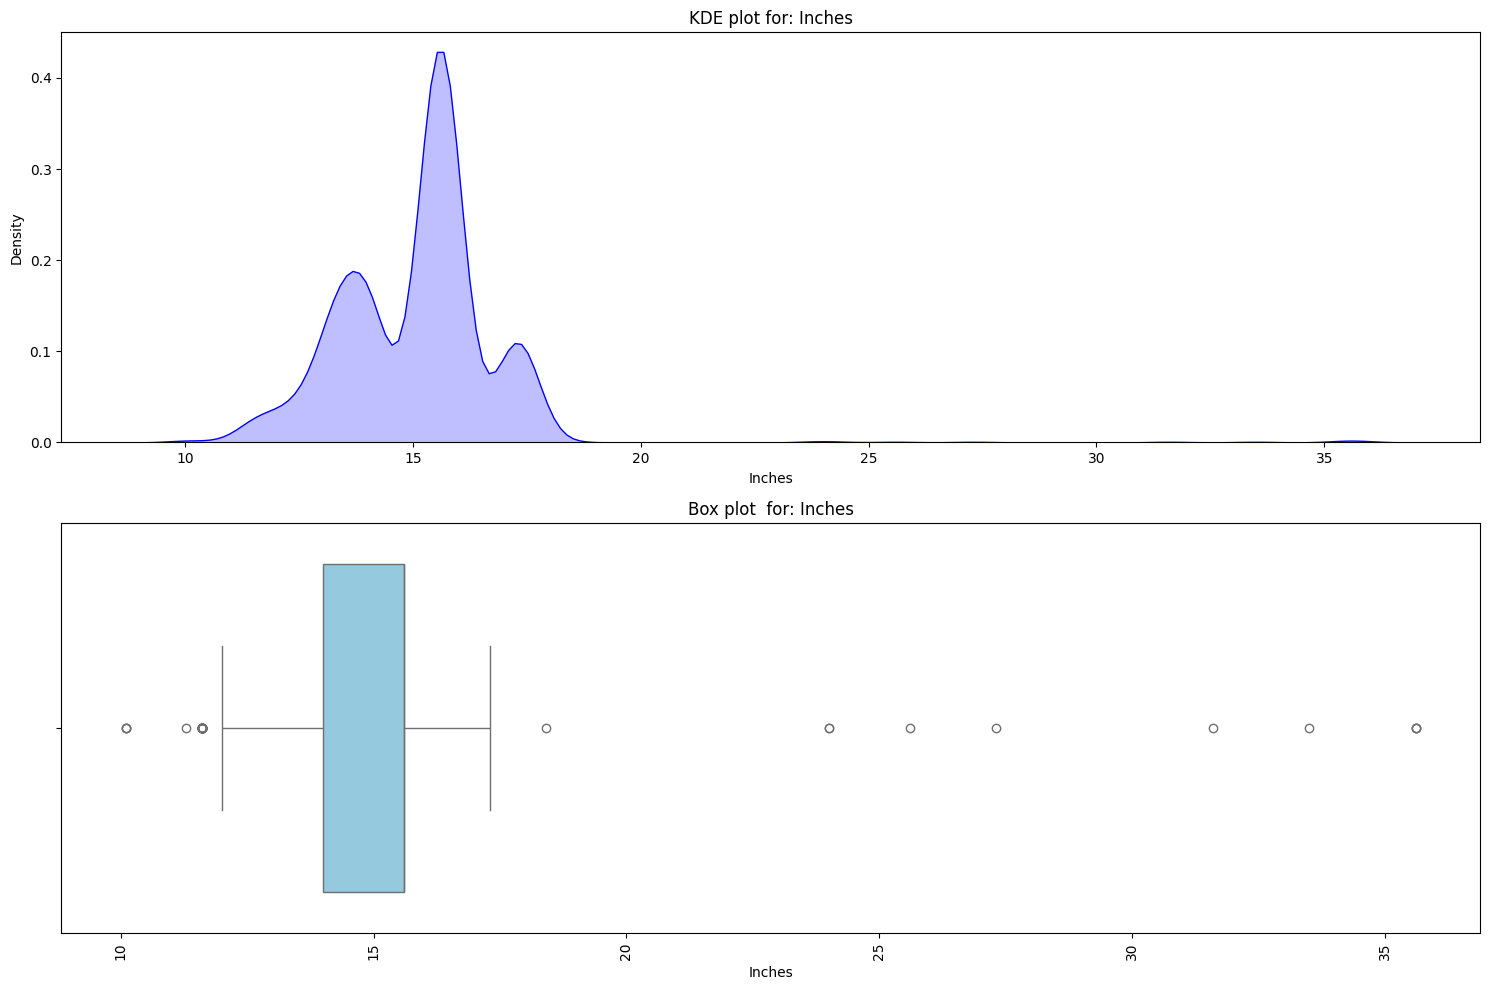

In [159]:
plot_num_data(df, 'Inches')

In [160]:
print(len(count_outliers(df, 'Inches')))

Number of outliers in Inches: 45
45


The KDE plot and the box plot shows a left skew with many outliers.

<h4>Weight:</h4>

In [161]:
print(df["Weight"].unique())

['1.37kg' '1.34kg' '1.86kg' '1.83kg' '2.1kg' '2.04kg' '1.3kg' '1.6kg'
 '2.2kg' '0.92kg' '1.22kg' '2.5kg' '1.62kg' '1.91kg' '2.3kg' '1.35kg'
 '1.88kg' '1.89kg' '1.65kg' '2.71kg' '1.2kg' '1.44kg' '2.8kg' '2kg'
 '2.65kg' '2.77kg' '3.2kg' '1.49kg' '2.4kg' '2.13kg' '2.43kg' '1.7kg'
 '1.4kg' '1.8kg' '1.9kg' '3kg' '1.252kg' '2.7kg' '2.02kg' '1.63kg'
 '1.96kg' '1.21kg' '2.45kg' '1.25kg' '1.5kg' '2.62kg' '1.38kg' '1.58kg'
 '1.85kg' '1.23kg' '2.16kg' '2.36kg' '7.2kg' '2.05kg' '1.32kg' '1.75kg'
 '0.97kg' '2.56kg' '1.48kg' '1.74kg' '1.1kg' '1.56kg' '2.03kg' '1.05kg'
 '5.4kg' '4.4kg' '1.90kg' '1.29kg' '2.0kg' '1.95kg' '2.06kg' '1.12kg'
 '3.49kg' '3.35kg' '2.23kg' '?' '2.9kg' '4.42kg' '2.69kg' '2.37kg' '4.7kg'
 '3.6kg' '2.08kg' '4.3kg' '1.68kg' '1.41kg' '4.14kg' '2.18kg' '2.24kg'
 '2.67kg' '4.1kg' '2.14kg' '1.36kg' '2.25kg' '2.15kg' '2.19kg' '2.54kg'
 '3.42kg' '5.8kg' '1.28kg' '2.33kg' '1.45kg' '2.79kg' '8.23kg' '1.26kg'
 '1.84kg' '0.0002kg' '2.6kg' '2.26kg' '3.25kg' '1.59kg' '1.13kg' '1.42kg'
 '1.7

In [162]:
df[df['Weight'] == '?']

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
208,208.0,Dell,Ultrabook,13.3,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,256GB SSD,Intel UHD Graphics 620,Windows 10,?,77202.72


We have to replace the missing value with the proper weight of the laptop which is 1.22kg.

Also since realistically weight below 1kg and above 5kg are not possible, we will drop those rows.

Weight column shows a bit of a right skew.

<h4>Screen Resolution:</h4>

In [163]:
df['ScreenResolution'].unique()

array(['IPS Panel Retina Display 2560x1600', '1440x900',
       'Full HD 1920x1080', 'IPS Panel Retina Display 2880x1800',
       '1366x768', 'IPS Panel Full HD 1920x1080',
       'IPS Panel Retina Display 2304x1440',
       'IPS Panel Full HD / Touchscreen 1920x1080',
       'Full HD / Touchscreen 1920x1080',
       'Touchscreen / Quad HD+ 3200x1800', 'Touchscreen 2256x1504',
       'Quad HD+ / Touchscreen 3200x1800', 'IPS Panel 1366x768',
       'IPS Panel 4K Ultra HD / Touchscreen 3840x2160',
       'IPS Panel Full HD 2160x1440',
       '4K Ultra HD / Touchscreen 3840x2160', '1600x900',
       'IPS Panel 4K Ultra HD 3840x2160', '4K Ultra HD 3840x2160',
       'Touchscreen 1366x768', 'Touchscreen 2560x1440',
       'IPS Panel Full HD 1366x768', 'IPS Panel 2560x1440',
       'IPS Panel Full HD 2560x1440',
       'IPS Panel Retina Display 2736x1824', 'Touchscreen 2400x1600',
       '2560x1440', 'IPS Panel Quad HD+ 2560x1440',
       'IPS Panel Quad HD+ 3200x1800',
       'IPS Panel Qua

We will seperate resolution for the axes and generate a new pixels per inch column.
Then, we should perform one-hot encoding for IPS panel, Touchscreen, Full HD, Quad HD/Quad HD+, Ultra HD/4K and Retina display.

<h4>Ram:</h4>

In [164]:
df['Ram'].value_counts()

Ram
8GB     601
4GB     367
16GB    194
6GB      40
12GB     25
2GB      22
32GB     17
64GB      3
24GB      3
1GB       1
Name: count, dtype: int64

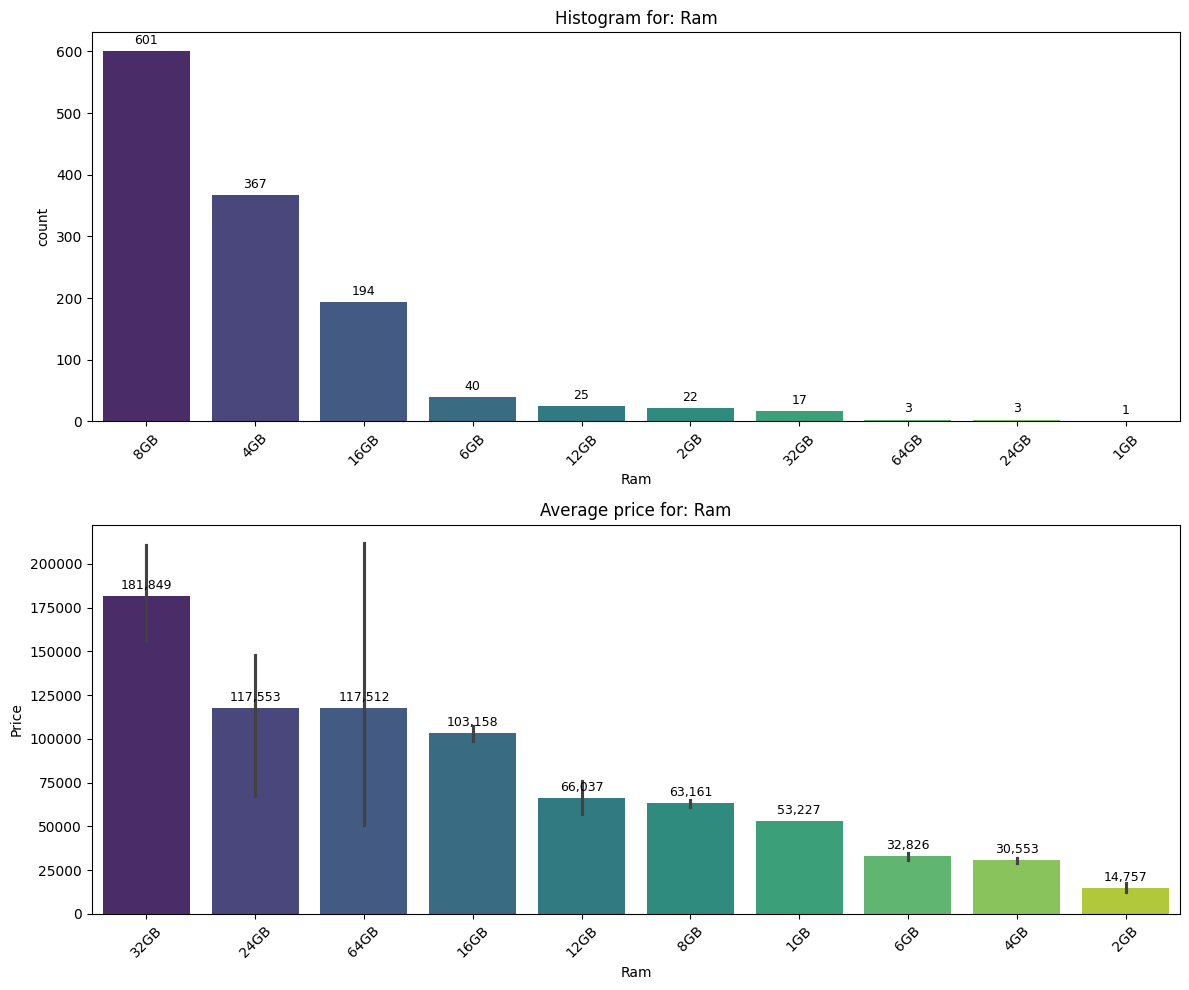

In [165]:
plot_cat_data(df, 'Ram')

The data is right skewed, we have to fix it for skewness later.

64GB Ram might be lower than 32GB Ram because the other specifications of 32GB devices might be better.

Secondly, we have to check the 1GB and 2GB ram rows to see whether those laptops actually exist.

In [166]:
# Show all rows where RAM is 1GB/2GB
df[df['Ram'] == '1GB']

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
706,706.0,Acer,2 in 1 Convertible,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 8250U 1.6GHz,1GB,256GB SSD,Intel UHD Graphics 620,Windows 10,1.6kg,53226.72


In [167]:
df[df['Ram'] == '2GB']

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
31,31.0,Asus,Notebook,14.0,1366x768,AMD E-Series E2-6110 1.5GHz,2GB,32GB Flash Storage,AMD Radeon R2,Windows 10,1.65kg,10602.720
91,91.0,Acer,Notebook,15.6,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,2GB,1TB HDD,Nvidia GeForce MX150,Windows 10,2.2kg,36709.920
290,290.0,Acer,Notebook,15.6,1366x768,Intel Celeron Dual Core 3205U 1.5GHz,2GB,16GB SSD,Intel HD Graphics,Chrome OS,2.19kg,10602.720
314,314.0,Asus,2 in 1 Convertible,11.6,Touchscreen 1366x768,Intel Celeron Dual Core N3350 1.1GHz,2GB,32GB Flash Storage,Intel HD Graphics 500,Windows 10,1.1kg,14652.000
346,346.0,HP,Notebook,14.0,1366x768,Intel Celeron Dual Core N3060 1.6GHz,2GB,32GB Flash Storage,Intel HD Graphics 400,Windows 10,1.44kg,14865.120
409,409.0,Lenovo,Notebook,11.6,1366x768,Intel Celeron Dual Core N3350 1.1GHz,2GB,32GB Flash Storage,Intel HD Graphics 500,Windows 10,1.15kg,16221.096
515,515.0,Asus,Netbook,11.6,1366x768,Intel Celeron Dual Core N3350 1.1GHz,2GB,32GB Flash Storage,Intel HD Graphics 500,Windows 10,1.1kg,13053.600
626,626.0,Mediacom,Notebook,14.0,Full HD 1920x1080,Intel Atom x5-Z8350 1.44GHz,2GB,32GB Flash Storage,Intel HD Graphics,Windows 10,1.4kg,12733.920
637,637.0,Lenovo,Notebook,14.0,1366x768,Intel Celeron Dual Core N3060 1.6GHz,2GB,32GB Flash Storage,Intel HD Graphics 400,Windows 10,1.42kg,13266.720
745,745.0,Acer,Notebook,14.0,1366x768,Intel Celeron Dual Core N3060 1.6GHz,2GB,32GB Flash Storage,Intel HD Graphics 400,Chrome OS,1.68kg,17582.400


Unlike the 1 GB Acer convertible we saw earlier (which was clearly a mismatch), these 2 GB entries are internally consistent — CPU, storage, resolution, and price all match expectations for low-RAM devices.
So we will only replace the value of 1GB Acer laptop whose proper RAM is 8GB.

In [168]:
df.loc[706, 'Ram'] = '8GB'

<h4>Company:</h4>

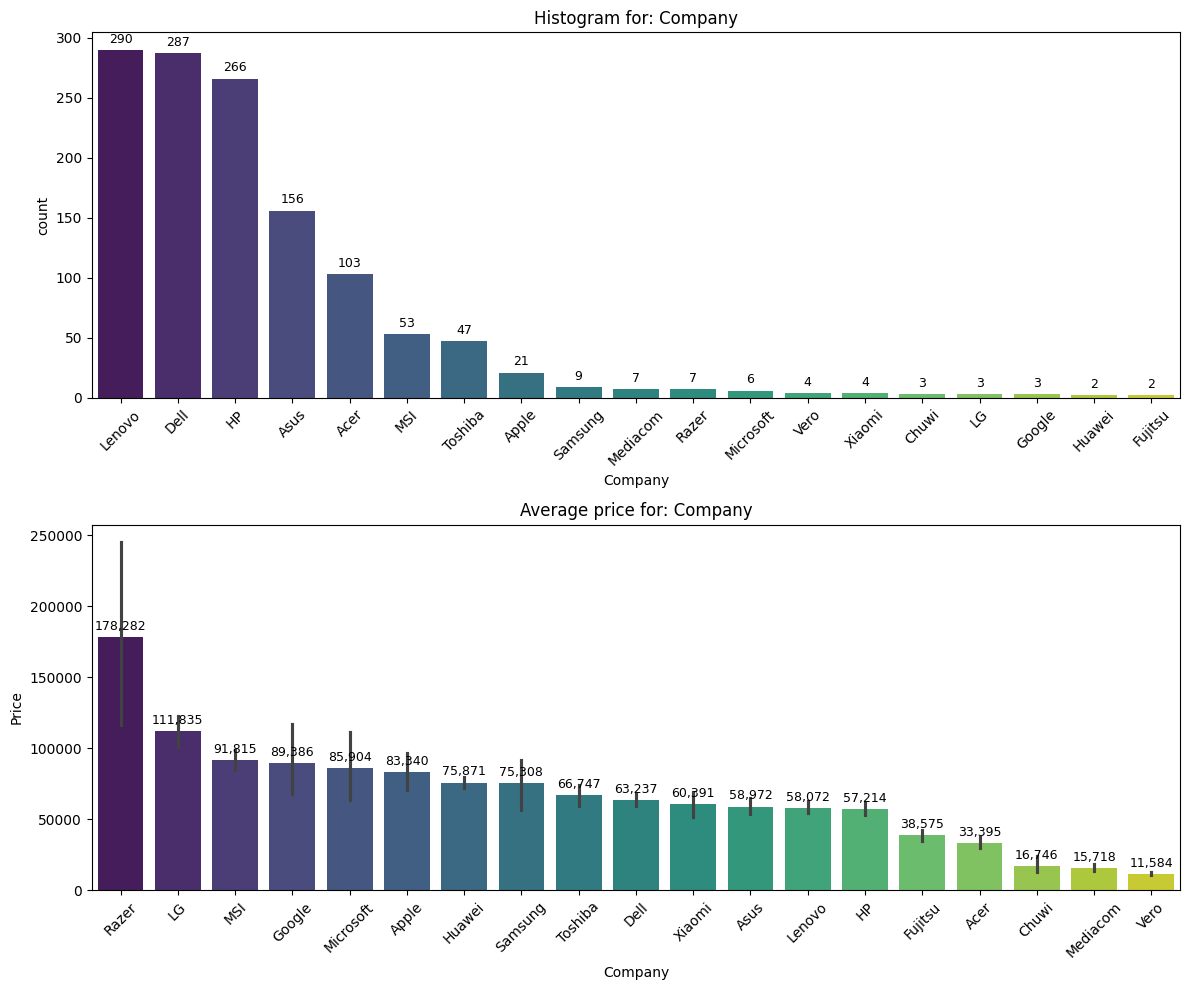

In [169]:
plot_cat_data(df, 'Company')

Since Vero is a subgroup of Acer, that rows will be merged to the 'Acer' rows.

The companies with less than 5 data entries will be categorized into a 'Other' group

<h4>TypeName:</h4>

In [170]:
print(df['TypeName'].value_counts())

TypeName
Notebook              710
Gaming                203
Ultrabook             191
2 in 1 Convertible    116
Workstation            29
Netbook                24
Name: count, dtype: int64


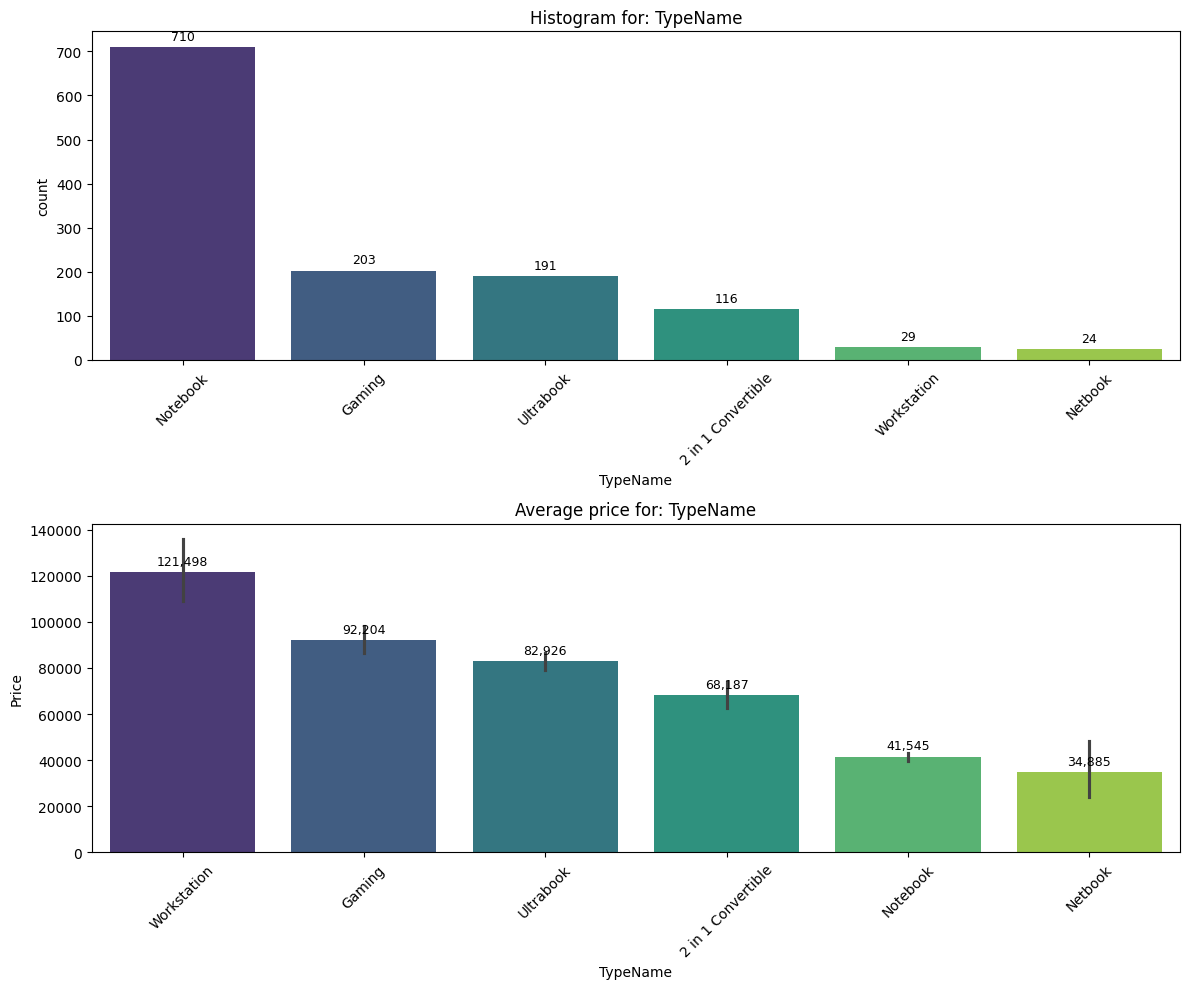

In [171]:
plot_cat_data(df, 'TypeName')

In [172]:
# Show all Netbook entries
df[df['TypeName'] == 'Netbook']

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
376,376.0,Lenovo,Netbook,11.6,IPS Panel 1366x768,Intel Celeron Quad Core N3450 1.1GHz,4GB,128GB SSD,Intel HD Graphics 500,Windows 10,1.59kg,29463.840
430,430.0,Samsung,Netbook,11.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,16GB Flash Storage,Intel HD Graphics 400,Chrome OS,1.15kg,14332.320
461,461.0,Acer,Netbook,11.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,128GB SSD,Intel HD Graphics 400,Windows 10,1.4kg,23176.800
500,500.0,Asus,Netbook,11.6,1366x768,Intel Celeron Dual Core N3350 1.1GHz,4GB,64GB Flash Storage,Intel HD Graphics 500,Windows 10 S,1.2kg,18115.200
504,504.0,Lenovo,Netbook,11.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,16GB SSD,Intel HD Graphics 400,Chrome OS,1.25kg,14119.200
515,515.0,Asus,Netbook,11.6,1366x768,Intel Celeron Dual Core N3350 1.1GHz,2GB,32GB Flash Storage,Intel HD Graphics 500,Windows 10,1.1kg,13053.600
584,584.0,Dell,Netbook,11.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,16GB Flash Storage,Intel HD Graphics 400,Chrome OS,1.26kg,15717.600
695,695.0,Acer,Netbook,11.6,1366x768,Intel Celeron Dual Core N3050 1.6GHz,4GB,32GB Flash Storage,Intel HD Graphics,Windows 10,1.4kg,14332.320
750,750.0,Lenovo,Netbook,11.6,Touchscreen 1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,128GB SSD,Intel HD Graphics 400,Windows 10,1.4kg,25308.000
804,804.0,Dell,Netbook,11.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4GB,128GB SSD,Intel HD Graphics 505,Windows 10,1.63kg,39640.320


Thus we check that netbook is not a type. The data entries are valid Netbook entries. They represent a distinct segment of the market — ultra-portable, low-cost laptops

<h4>Memory:</h4>

In [173]:
df['Memory'].unique()

array(['128GB SSD', '128GB Flash Storage', '256GB SSD', '512GB SSD',
       '500GB HDD', '256GB Flash Storage', '1TB HDD',
       '128GB SSD +  1TB HDD', '256GB SSD +  256GB SSD',
       '64GB Flash Storage', '32GB Flash Storage', '256GB SSD +  1TB HDD',
       '256GB SSD +  2TB HDD', '32GB SSD', '2TB HDD', '64GB SSD',
       '1.0TB Hybrid', '512GB SSD +  1TB HDD', '1TB SSD',
       '256GB SSD +  500GB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  512GB SSD', '16GB SSD', '16GB Flash Storage',
       '512GB SSD +  256GB SSD', '512GB SSD +  2TB HDD',
       '64GB Flash Storage +  1TB HDD', '180GB SSD', '1TB HDD +  1TB HDD',
       '32GB HDD', '1TB SSD +  1TB HDD', '?', '512GB Flash Storage',
       '128GB HDD', '240GB SSD', '8GB SSD', '508GB Hybrid', '1.0TB HDD',
       '512GB SSD +  1.0TB Hybrid', '256GB SSD +  1.0TB Hybrid'],
      dtype=object)

We will convert TB to GB and seperate the data into 4 columns of SSD, HDD, Flash drive and Hybrid storage. There is also some unknown values.

In [174]:
# Find rows where all storage types are unknown
zero_rows = df[(df['Memory'] == '?')]

print(f"Number of unknown rows: {len(zero_rows)}")
display(zero_rows)

Number of unknown rows: 1


,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
770,770.0,Dell,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,?,AMD Radeon R7 M445,Windows 10,2.3kg,62938.0656


Since there is just one data, we will look up its actual storage values and input them.

In [175]:
df.loc[770, 'Memory'] = '128GB SSD + 1TB HDD'

<h4>GPU:</h4>

In [176]:
df['Gpu'].unique()

array(['Intel Iris Plus Graphics 640', 'Intel HD Graphics 6000',
       'Intel HD Graphics 620', 'AMD Radeon Pro 455',
       'Intel Iris Plus Graphics 650', 'AMD Radeon R5',
       'Intel Iris Pro Graphics', 'Nvidia GeForce MX150',
       'Intel UHD Graphics 620', 'Intel HD Graphics 520',
       'AMD Radeon Pro 555', 'AMD Radeon R5 M430',
       'Intel HD Graphics 615', 'AMD Radeon Pro 560',
       'Nvidia GeForce 940MX', 'Nvidia GeForce GTX 1050', 'AMD Radeon R2',
       'AMD Radeon 530', 'Nvidia GeForce 930MX', 'Intel HD Graphics',
       'Intel HD Graphics 500', 'Nvidia GeForce 930MX ',
       'Nvidia GeForce GTX 1060', 'Nvidia GeForce 150MX',
       'Intel Iris Graphics 540', 'AMD Radeon RX 580',
       'Nvidia GeForce 920MX', 'AMD Radeon R4 Graphics', 'AMD Radeon 520',
       'Nvidia GeForce GTX 1070', 'Nvidia GeForce GTX 1050 Ti',
       'Intel HD Graphics 400', 'Nvidia GeForce MX130', 'AMD R4 Graphics',
       'Nvidia GeForce GTX 940MX', 'AMD Radeon RX 560',
       'Nvidia GeFo

We will separate by brand only and keep a flag for dedicated gpu.

<h4>CPU</h4>

In [177]:
df['Cpu'].unique()

array(['Intel Core i5 2.3GHz', 'Intel Core i5 1.8GHz',
       'Intel Core i5 7200U 2.5GHz', 'Intel Core i7 2.7GHz',
       'Intel Core i5 3.1GHz', 'AMD A9-Series 9420 3GHz',
       'Intel Core i7 2.2GHz', 'Intel Core i7 8550U 1.8GHz',
       'Intel Core i5 8250U 1.6GHz', 'Intel Core i3 6006U 2GHz',
       'Intel Core i7 2.8GHz', 'Intel Core M m3 1.2GHz',
       'Intel Core i7 7500U 2.7GHz', 'Intel Core i7 2.9GHz',
       'Intel Core i3 7100U 2.4GHz', 'Intel Core i5 7300HQ 2.5GHz',
       'AMD E-Series E2-9000e 1.5GHz', 'Intel Core i5 1.6GHz',
       'Intel Core i7 8650U 1.9GHz', 'Intel Atom x5-Z8300 1.44GHz',
       'AMD E-Series E2-6110 1.5GHz', 'AMD A6-Series 9220 2.5GHz',
       'Intel Celeron Dual Core N3350 1.1GHz',
       'Intel Core i3 7130U 2.7GHz', 'Intel Core i7 7700HQ 2.8GHz',
       'Intel Core i5 2.0GHz', 'AMD Ryzen 1700 3GHz',
       'Intel Pentium Quad Core N4200 1.1GHz',
       'Intel Celeron Dual Core N3060 1.6GHz', 'Intel Core i5 1.3GHz',
       'AMD FX 9830P 3GHz', '

This column will be grouped into two new columns - cpu brand and cpu tier.

<h4>Operating System:</h4>

In [178]:
df['OpSys'].unique()

array(['macOS', 'No OS', 'Windows 10', 'Mac OS X', 'Linux',
       'Windows 10 S', 'Chrome OS', 'Windows 7', 'Android'], dtype=object)

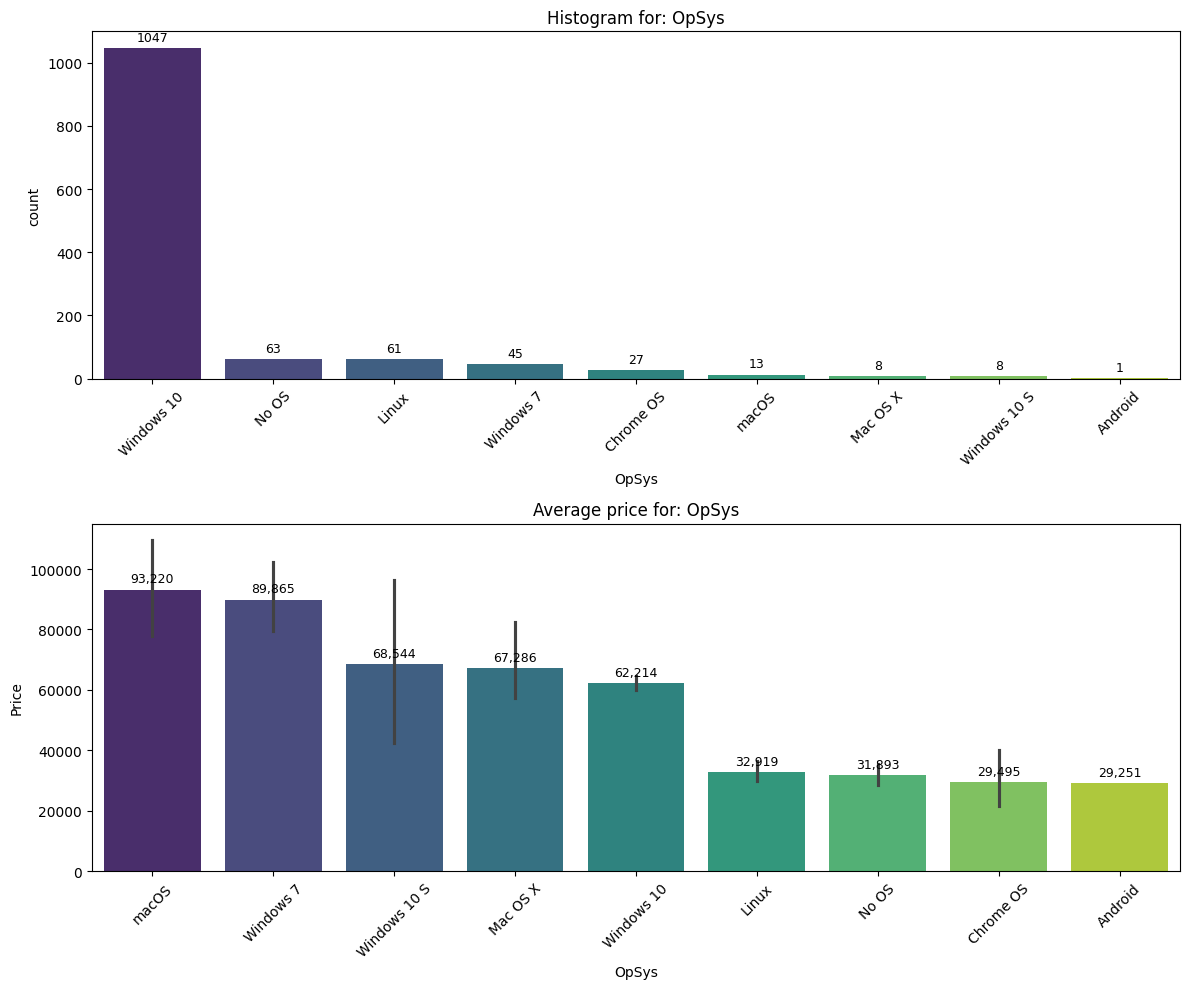

In [179]:
plot_cat_data(df, 'OpSys')

The windows os can be grouped together. Since linux, chrome os and no os has little data, they will be grouped to an 'other' category.

In [180]:
print(df.shape)

(1273, 12)


This is the end of data exploration.

<h4>Column Sector</h4>

In [181]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.columns = cols
    def fit(self, X, y=None):
        return self 
    def transform(self, X, y=None):
        X = X[self.columns]
        return X 
    def fit_transform(self, X, y = None):
        return self.transform(X)
    
    def inverse_transform(self, X, y=None):
        return X
        

<h4>Fixing Data Types</h4>

In [182]:
class DataTypeFixer(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols or []
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()

        # Manual fix for RAM at index 674
        if 674 in X_copy.index:
            X_copy.loc[674, 'Ram'] = '8GB'

        # Manual fix for Memory at index 734
        if 734 in X_copy.index and str(X_copy.loc[734, 'Memory']).strip() == '?':
            X_copy.loc[734, 'Memory'] = '128GB SSD + 1TB HDD'

        for col in self.cols:
            if col == "Inches":
                X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
                X_copy[col] = X_copy[col].fillna(X_copy[col].mean())
                X_copy[col] = X_copy[col].apply(lambda x: x / 2.54 if x > 17.5 else x)
                X_copy[col] = X_copy[col].round(1)

            elif col == "Ram":
                X_copy[col] = X_copy[col].astype(str)
                X_copy[col] = pd.to_numeric(
                    X_copy[col].str.replace('GB', '').str.strip(), errors='coerce'
                )
                X_copy[col] = X_copy[col].fillna(X_copy[col].mean())

            elif col == "Weight":
                X_copy[col] = X_copy[col].astype(str)
                
                X_copy[col] = X_copy[col].replace('?', '1.22kg')
                X_copy[col] = pd.to_numeric(
                    X_copy[col].str.replace('kg', '').str.strip(), errors='coerce'
                )
                X_copy[col] = X_copy[col].fillna(X_copy[col].mean())
                X_copy[col] = X_copy[col].clip(lower=1.0, upper=5.0)

        
        return X_copy
    
    
    def get_feature_names_out(self, input_features=None):
        return np.array(input_features if input_features is not None else self.cols)
    
    def inverse_transform(self, X, y=None):
        return X

<h4>Feature Extraction</h4>

In [183]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
import re

class FeatureExtract(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    @staticmethod
    def process_screen_resolution(df):
        df[['ResX', 'ResY']] = df['ScreenResolution'].str.extract(r'(\d+)x(\d+)').astype(float)
        df['PPI'] = ((df['ResX']**2 + df['ResY']**2) ** 0.5) / df['Inches']
        df['IPS'] = df['ScreenResolution'].str.contains('IPS', case=False, na=False).astype(int)
        df['Touchscreen'] = df['ScreenResolution'].str.contains('Touchscreen', case=False, na=False).astype(int)
        df['FullHD'] = df['ScreenResolution'].str.contains('Full HD', case=False, na=False).astype(int)
        df['QuadHD'] = df['ScreenResolution'].str.contains('Quad HD', case=False, na=False).astype(int)
        df['UltraHD_4K'] = df['ScreenResolution'].str.contains('4K Ultra HD|3840x2160', case=False, na=False).astype(int)
        df['Retina'] = df['ScreenResolution'].str.contains('Retina', case=False, na=False).astype(int)
        return df

    @staticmethod
    def process_company(df):
        df['Company'] = df['Company'].replace({'Vero': 'Acer'})
        rare_companies = df['Company'].value_counts()[lambda x: x < 5].index
        df['Company'] = df['Company'].replace(rare_companies, 'Other')
        return df

    @staticmethod
    def process_typename(df):
        df['TypeName'] = df['TypeName'].replace({'2 in 1 Convertible': 'Convertible'})
        return df

    @staticmethod
    def process_memory(df):
        df['Memory'] = df['Memory'].replace('?', np.nan)
        series = df['Memory'].fillna('').astype(str).str.strip()
        series = (series
                  .str.replace(r'\s*\+\s*', ' + ', regex=True)
                  .str.replace(r'Flash\s*Storage', 'Flash', regex=True))

        pattern = re.compile(
            r'(?P<size>\d*\.?\d+)\s*(?P<unit>TB|GB)\s*(?P<type>SSD|HDD|Hybrid|Flash)',
            flags=re.IGNORECASE
        )

        hdd, ssd, flash, hybrid = [], [], [], []
        for s in series:
            total_hdd = total_ssd = total_flash = total_hybrid = 0.0
            for m in pattern.finditer(s):
                size = float(m.group('size'))
                unit = m.group('unit').upper()
                dtype = m.group('type').lower()
                gb = size * (1024.0 if unit == 'TB' else 1.0)
                if dtype == 'hdd':
                    total_hdd += gb
                elif dtype == 'ssd':
                    total_ssd += gb
                elif dtype == 'flash':
                    total_flash += gb
                elif dtype == 'hybrid':
                    total_hybrid += gb
            hdd.append(total_hdd)
            ssd.append(total_ssd)
            flash.append(total_flash)
            hybrid.append(total_hybrid)

        df['HDD'] = np.round(hdd).astype(int)
        df['SSD'] = np.round(ssd).astype(int)
        df['Flash'] = np.round(flash).astype(int)
        df['Hybrid'] = np.round(hybrid).astype(int)

        # if 734 in df.index:
        #     df.loc[734, 'Memory'] = '128GB SSD + 1TB HDD'
        #     df.loc[734, 'SSD'] = 128
        #     df.loc[734, 'HDD'] = 1024

        return df

    @staticmethod
    def process_cpu(df):
        df['Cpu'] = df['Cpu'].str.strip()
        df['CpuBrand'] = df['Cpu'].str.split().str[0].replace({'Samsung': 'AMD'})
        #df['CpuClock'] = df['Cpu'].str.extract(r'(\d+\.\d+)GHz').astype(float)
        
        df['CpuClock'] = pd.to_numeric(
                df['Cpu'].str.extract(r'(\d+\.\d+)GHz')[0], errors='coerce'
            )

        def cpu_tier(cpu):
            cpu_lower = cpu.lower()
            if any(x in cpu_lower for x in ['i7', 'i9', 'ryzen 7', 'ryzen 9']):
                return 'High'
            elif any(x in cpu_lower for x in ['i5', 'ryzen 5']):
                return 'Mid'
            else:
                return 'Low'

        df['CpuTier'] = df['Cpu'].apply(cpu_tier)
        return df

    @staticmethod
    def process_gpu(df):
        df['Gpu'] = df['Gpu'].str.strip()
        df['GpuBrand'] = df['Gpu'].str.split().str[0]
        df['DedicatedGPU'] = df['GpuBrand'].apply(lambda x: 1 if x in ['Nvidia', 'AMD'] else 0)
        return df

    @staticmethod
    def process_os(df):
        df['OpSys'] = df['OpSys'].replace({
            'Mac OS X': 'MacOS',
            'macOS': 'MacOS',
            'Windows 10 S': 'Windows 10',
            'Windows 7': 'Windows 10',
            'Linux': 'Other OS',
            'Chrome OS': 'Other OS',
            'No OS': 'Other OS'
        }).replace({'Windows 10': 'Windows'})
        return df

    def transform(self, X, y=None):
        df = X.copy()
        df = self.process_gpu(df)
        df = self.process_memory(df)
        df = self.process_os(df)
        df = self.process_screen_resolution(df)
        df = self.process_cpu(df)
        df = self.process_company(df)
        df = self.process_typename(df)
        return df
    
    def get_feature_names_out(self, input_features=None):
        # Return original + engineered columns
        # If you know exactly which engineered features you add, list them here
        engineered = [
            'ResX','ResY','PPI','IPS','Touchscreen','FullHD','QuadHD','UltraHD_4K','Retina',
            'CpuBrand','CpuClock','CpuTier',
            'GpuBrand','DedicatedGPU',
            'HDD','SSD','Flash','Hybrid',
            'OpSys'
        ]
        # Keep original columns that remain relevant
        base = input_features if input_features is not None else []
        return np.array(list(base) + engineered)
    
    def inverse_transform(self, X, y=None):
        return X

<h4>One Hot Encoding</h4>

In [184]:
class OneHot(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols  #which columns I want to encode
        self.encoder = None
        self.columnNames = None  #placeholder for names of new encoded columns
        
    def fit(self, X, y=None):
        self.encoder = OneHotEncoder(sparse_output=False, drop = 'first')
        self.encoder.fit(X[self.cols])
        self.column_names = self.encoder.get_feature_names_out(self.cols)
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        encoded = self.encoder.transform(X_copy[self.cols])
        encodedDF = pd.DataFrame(encoded, columns = self.column_names, index = X_copy.index)
        X_copy.drop(columns=self.cols, inplace = True)
        
        X_copy = pd.concat([X_copy, encodedDF], axis = 1)
        return X_copy
    
    
    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        return self.column_names

<h4>Skew Fixer</h4>

In [185]:
def skewness_heatmap(df, numCol, centre_val = 0):
    skew_df = pd.DataFrame(df[numCol].skew().sort_values(), columns = ['Skewness'])
    
    sns.heatmap(skew_df, cmap = 'viridis', annot = True, fmt = ".2f", cbar = True, center = centre_val, vmin = abs(skew_df).max().max(), vmax = abs(skew_df).max().max())
    
    plt.title("Skewness Heatmap")
    plt.xlabel("Skewness")
    plt.ylabel("Features")
    plt.axvline(x=1, color='grey', linestyle='--')
    plt.axvline(x=-1, color='grey', linestyle='--')
    plt.show()

In [228]:
from scipy.stats import boxcox, yeojohnson
from typing import Dict, Any, Optional
from scipy.special import inv_boxcox

class SkewFixer(BaseEstimator, TransformerMixin):
    def __init__(self, cols: Optional[list] = None,
                 skew_threshold_left: float = -1.0,
                 skew_threshold_right: float = 1.0,
                 prefer_simplicity: bool = True,
                 allow_log1p_for_zeros: bool = True,
                 handle_nans: str = 'passthrough'):
        
        self.cols = cols
        self.skew_threshold_left = skew_threshold_left
        self.skew_threshold_right = skew_threshold_right
        self.prefer_simplicity = prefer_simplicity
        self.allow_log1p_for_zeros = allow_log1p_for_zeros
        self.handle_nans = handle_nans
        
        self.decisions_: Dict[str, Dict[str, Any]] = {}
        self.skewed_: list = []
        self.selected_cols_: list = []
        
    def _abs_skew(self, s: pd.Series) -> float:
        return float(pd.Series(s).skew())
    
    def _transform_with_choice(self, x: pd.Series, choice: Dict[str, Any]) -> pd.Series:
        name = choice['name']
        lam = choice.get('lambda', None)
        
        if name == 'identity':
            return x
        if name == 'log':
            return np.log(x)
        if name == 'log1p':
            return np.log1p(x)
        if name == 'boxcox':
            return pd.Series(boxcox(x.to_numpy(), lmbda=lam), index=x.index)
        if name == 'yeojohnson':
            return pd.Series(yeojohnson(x.to_numpy(), lmbda=lam), index=x.index)
        
        raise ValueError(f"Unknown transform choice: {name}")
    
    def fit(self, X: pd.DataFrame, y=None):
        self.decisions_ = {}
        self.skewed_ = []
        X_num = X.copy()
        
        if self.cols is None:
            self.selected_cols_ = list(X_num.select_dtypes(include=[np.number]).columns)
        else:
            self.selected_cols_ = list(self.cols)
            
        for col in self.selected_cols_:
            s = X_num[col]
            s_fit = s.dropna()
            
            if s_fit.nunique(dropna=True) <= 1:
                self.decisions_[col] = {'name': 'identity'}
                continue
            
            sk = s_fit.skew()
            if not (sk < self.skew_threshold_left or sk > self.skew_threshold_right):
                self.decisions_[col] = {'name': 'identity'}
                continue
            
            self.skewed_.append(col)
            candidates = []
            s_min = s_fit.min()
            
            if s_min > 0:
                try:
                    t = np.log(s_fit)
                    candidates.append(('log', None, abs(pd.Series(t).skew())))
                except Exception:
                    pass
            
            if self.allow_log1p_for_zeros and s_min >= 0:
                try:
                    t = np.log1p(s_fit)
                    candidates.append(('log1p', None, abs(pd.Series(t).skew())))
                except Exception:
                    pass
            
            if s_min > 0:
                try:
                    t_bc, lam_bc = boxcox(s_fit.to_numpy())
                    candidates.append(('boxcox', lam_bc, abs(pd.Series(t_bc).skew())))
                except Exception:
                    pass
            
            try:
                t_yj, lam_yj = yeojohnson(s_fit.to_numpy())
                candidates.append(('yeojohnson', lam_yj, abs(pd.Series(t_yj).skew())))
            except Exception:
                pass
            
            if not candidates:
                self.decisions_[col] = {'name': 'identity'}
                continue
            
            candidates.sort(key=lambda x: (
                x[2],
                {'log': 0, 'log1p': 1, 'boxcox': 2, 'yeojohnson': 3}[x[0]] if self.prefer_simplicity else 0
            ))
            
            name_best, lam_best, _ = candidates[0]
            self.decisions_[col] = {'name': name_best, 'lambda': lam_best}
            
        return self
        
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        if not hasattr(self, 'decisions_'):
            raise RuntimeError("SkewFixer must be fitted before calling transform().")
            
        X_copy = X.copy()
        
        for col in self.selected_cols_:
            choice = self.decisions_.get(col, {'name': 'identity'})
            if choice['name'] == 'identity':
                continue
            
            s = X_copy[col]
            mask = s.notna()
            s_trans = s.copy()
            
            if choice['name'] in ('log', 'boxcox') and (s[mask] <= 0).any():
                # fallback to yeojohnson if available
                fallback = {'name': 'yeojohnson', 'lambda': None}
                s_trans.loc[mask] = self._transform_with_choice(s[mask], fallback)
            else:
                s_trans.loc[mask] = self._transform_with_choice(s[mask], choice)
            
            X_copy[col] = s_trans
            
        return X_copy
    
    def fit_transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        return self.fit(X, y).transform(X)
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.selected_cols_)
    
    def inverse_transform(self, X, y=None):
        X_copy = X.copy()

        # If input is a NumPy array, assume column order matches self.selected_cols_
        if isinstance(X_copy, np.ndarray):
            for i, col in enumerate(self.selected_cols_):
                choice = self.decisions_.get(col, {'name': 'identity'})
                if choice['name'] == 'identity':
                    continue
                s = X_copy[:, i]
                if choice['name'] == 'log':
                    X_copy[:, i] = np.exp(s)
                elif choice['name'] == 'log1p':
                    X_copy[:, i] = np.expm1(s)
                elif choice['name'] == 'boxcox':
                    lam = choice.get('lambda', None)
                    X_copy[:, i] = inv_boxcox(s, lam)
                elif choice['name'] == 'yeojohnson':
                    lam = choice.get('lambda', None)
                    x = s
                    if lam == 0:
                        inv = np.expm1(x)
                    elif lam == 2:
                        inv = 1 - np.exp(-x)
                    else:
                        pos = x >= 0
                        neg = ~pos
                        inv = np.empty_like(x)
                        inv[pos] = np.power(x[pos] * lam + 1, 1/lam) - 1
                        inv[neg] = 1 - np.power(-(2 - lam) * x[neg] + 1, 1/(2 - lam))
                    X_copy[:, i] = inv

            return X_copy

        #  If input is a DataFrame, use column names
        for col in self.selected_cols_:
            choice = self.decisions_.get(col, {'name': 'identity'})
            if choice['name'] == 'identity':
                continue
            s = X_copy[col]
            if choice['name'] == 'log':
                X_copy[col] = np.exp(s)
            elif choice['name'] == 'log1p':
                X_copy[col] = np.expm1(s)
            elif choice['name'] == 'boxcox':
                lam = choice.get('lambda', None)
                X_copy[col] = inv_boxcox(s, lam)
            elif choice['name'] == 'yeojohnson':
                lam = choice.get('lambda', None)
                x = s.to_numpy()
                if lam == 0:
                    inv = np.expm1(x)
                elif lam == 2:
                    inv = 1 - np.exp(-x)
                else:
                    pos = x >= 0
                    neg = ~pos
                    inv = np.empty_like(x)
                    inv[pos] = np.power(x[pos] * lam + 1, 1/lam) - 1
                    inv[neg] = 1 - np.power(-(2 - lam) * x[neg] + 1, 1/(2 - lam))
                X_copy[col] = inv
        return X_copy

<h4>Scaling</h4>

We use the Shapiro test. If data is relatively normally distributed, we use standard scaling. Else, we use a min-max scaler.

In [224]:
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, cols ):
        self.cols = cols
        self.scalers= {}
        
    def fit(self, X, y=None):
        self.scalers = {}
        
        for col in self.cols:
            stat, p = shapiro(X[col])
            if p > 0.05:
                scaler = StandardScaler()
            else:
                scaler = MinMaxScaler()
                
            scaler.fit(X[[col]])
            self.scalers[col] = scaler
            
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in self.cols:
            X_copy[col] = self.scalers[col].transform(X_copy[[col]]).flatten()
            
        return X_copy
    
    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.cols)
    
    def inverse_transform(self, X, y=None):
        X_copy = X.copy()
    
        # If input is a NumPy array, assume column order matches self.cols
        if isinstance(X_copy, np.ndarray):
            for i, col in enumerate(self.cols):
                X_copy[:, i] = self.scalers[col].inverse_transform(X_copy[:, [i]]).flatten()
            return X_copy
    
        # If input is a DataFrame, use column names
        for col in self.cols:
            X_copy[col] = self.scalers[col].inverse_transform(X_copy[[col]]).flatten()
        return X_copy


<h4>Full Pipeline</h4>

In [229]:
from sklearn.compose import ColumnTransformer

class Full_pipeline:
    def __init__(self, use_y_pipeline = True):
        self.use_y_pipeline = use_y_pipeline
        
        self.numeric_cols = [
            'Inches', 'Weight', 'Ram', 'PPI',
            'HDD', 'SSD', 'Flash', 'Hybrid', 'CpuClock'
            ]

        self.categorical_cols = [
            'TypeName', 'Company', 'CpuBrand', 'CpuTier',
            'GpuBrand', 'OpSys'
        ]
        
        numeric_pipeline = Pipeline([
            ("skew", SkewFixer(cols=self.numeric_cols)),
            ("scale", Scaler(cols=self.numeric_cols)),
            ("imputer", SimpleImputer(strategy="mean")) 
        ])
        
        categorical_pipeline = Pipeline([
            ("onehot", OneHot(cols = self.categorical_cols))
        ])
        
        #parallel processing
        
        preprocessor = ColumnTransformer([
            ("numeric", numeric_pipeline, self.numeric_cols),
            ("categorical", categorical_pipeline, self.categorical_cols)
        ], remainder="drop")
        
        self.full_pipeline = Pipeline([
            ("type_fix", DataTypeFixer(cols=['Inches','Weight','Ram'])),
            ("feature_extract", FeatureExtract()),
            ("preprocessor", preprocessor)
        ])
        
        
        if self.use_y_pipeline:
            self.y_pipeline = Pipeline([
                ('selector', ColumnSelector(cols=['Price'])),
                ('power_transformation', SkewFixer(cols=['Price'])),
                ('scaling', Scaler(cols=['Price']))
            ])
        else:
            self.y_pipeline = None
    
    def fit_transform(self, X_train, y_train = None):
        X_train = self.full_pipeline.fit_transform(X_train)
        if self.use_y_pipeline and y_train is not None:
            y_train = self.y_pipeline.fit_transform(y_train)
        
        return X_train, y_train
    
    def transform(self, X_test, y_test=None):
        X_test = self.full_pipeline.transform(X_test)
        if self.use_y_pipeline and y_test is not None:
            y_test = self.y_pipeline.transform(y_test)
        
        return X_test, y_test
        

Now we split the data and process it.

In [189]:
X = df.drop(columns=['Price'])
Y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

In [190]:
#Before feature extraction
print(X_train.head(5))

      Unnamed: 0 Company            TypeName  Inches  \
950        950.0      HP         Workstation    15.6   
1121      1121.0      HP            Notebook    13.3   
1292      1292.0    Dell            Notebook    15.6   
1247      1247.0    Asus              Gaming    15.6   
306        306.0      HP  2 in 1 Convertible    13.3   

                     ScreenResolution                                   Cpu  \
950       IPS Panel Full HD 1920x1080           Intel Core i7 6820HQ 2.7GHz   
1121                Full HD 1920x1080            Intel Core i5 6200U 2.3GHz   
1292                         1366x768  Intel Celeron Dual Core N3050 1.6GHz   
1247      IPS Panel Full HD 1920x1080           Intel Core i7 6700HQ 2.6GHz   
306   Full HD / Touchscreen 1920x1080            Intel Core i7 7600U 2.8GHz   

       Ram                Memory                      Gpu       OpSys  Weight  
950    8GB               8GB SSD     Nvidia Quadro M1000M  Windows 10   2.0kg  
1121   8GB             256GB

In [230]:
full_pipeline1 = Full_pipeline(use_y_pipeline = True)
y_train_df = pd.DataFrame(y_train)


X_train_pre, y_train_pre = full_pipeline1.fit_transform(X_train, y_train_df)

In [192]:
# After feature extraction

# Get feature names from the ColumnTransformer
feature_names = full_pipeline1.full_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Wrap into a DataFrame
X_train_pre_df = pd.DataFrame(X_train_pre, columns=feature_names)
print(X_train_pre_df.head())

   numeric__Inches  numeric__Weight  numeric__Ram  numeric__PPI  numeric__HDD  \
0         0.831683         0.476102      0.487696      0.506642      0.000000   
1         0.603960         0.108395      0.487696      0.633888      0.000000   
2         0.831683         0.535857      0.000000      0.142202      0.244141   
3         0.831683         0.573847      0.693509      0.506642      0.500000   
4         0.603960         0.178284      0.693509      0.633888      0.000000   

   numeric__SSD  numeric__Flash  numeric__Hybrid  numeric__CpuClock  \
0      0.164113             0.0              0.0           0.666667   
1      0.653795             0.0              0.0           0.518519   
2      0.000000             0.0              0.0           0.259259   
3      0.653795             0.0              0.0           0.629630   
4      0.653795             0.0              0.0           0.703704   

   categorical__TypeName_Gaming  ...  categorical__Company_Toshiba  \
0               

In [193]:
print("X_train_pre shape:", X_train_pre.shape)
print("Number of feature names:", len(feature_names))
print("Feature names:", feature_names[:])

X_train_pre shape: (1082, 34)
Number of feature names: 34
Feature names: ['numeric__Inches' 'numeric__Weight' 'numeric__Ram' 'numeric__PPI'
 'numeric__HDD' 'numeric__SSD' 'numeric__Flash' 'numeric__Hybrid'
 'numeric__CpuClock' 'categorical__TypeName_Gaming'
 'categorical__TypeName_Netbook' 'categorical__TypeName_Notebook'
 'categorical__TypeName_Ultrabook' 'categorical__TypeName_Workstation'
 'categorical__Company_Apple' 'categorical__Company_Asus'
 'categorical__Company_Dell' 'categorical__Company_HP'
 'categorical__Company_Lenovo' 'categorical__Company_MSI'
 'categorical__Company_Mediacom' 'categorical__Company_Other'
 'categorical__Company_Razer' 'categorical__Company_Samsung'
 'categorical__Company_Toshiba' 'categorical__CpuBrand_Intel'
 'categorical__CpuTier_Low' 'categorical__CpuTier_Mid'
 'categorical__GpuBrand_ARM' 'categorical__GpuBrand_Intel'
 'categorical__GpuBrand_Nvidia' 'categorical__OpSys_MacOS'
 'categorical__OpSys_Other OS' 'categorical__OpSys_Windows']


In [194]:
y_test_df = pd.DataFrame(y_test, columns=['Price'])
X_test_pre, y_test_pre = full_pipeline1.transform(X_test, y_test_df)

<h4>Modeling</h4>

In [195]:
models = [
    LinearRegression(),
    Ridge(random_state=ord("S")),
    Lasso(random_state=ord("S")),
    ElasticNet(random_state=ord("S")),
    DecisionTreeRegressor(random_state=ord("S")),
    RandomForestRegressor(random_state=ord("S")),
    GradientBoostingRegressor(random_state=ord("S")),
    XGBRegressor(random_state=ord("S")),
    ExtraTreesRegressor(random_state=ord("S")),
    BaggingRegressor(random_state=ord("S")),
    AdaBoostRegressor(random_state=ord("S")),
    CatBoostRegressor(random_state=ord("S"),verbose=False),
    SVR(),
    KNeighborsRegressor()
]

In [196]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    mask = y_true != 0
    
    return np.mean(np.abs((y_true[mask] - y_pred[mask])/y_true[mask]))*100

In [197]:
def evaluate_models(models, X_train, y_train, X_test, y_test, cv):
    results = []
    
    for model in models:
        scores = cross_validate(
            model, X_train, y_train, cv = cv,
            scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
            return_train_score=True
        )
        
        mean_train_mae = -np.mean(scores['train_neg_mean_absolute_error'])
        mean_train_mse = -np.mean(scores['train_neg_mean_squared_error'])
        mean_train_rmse = np.sqrt(mean_train_mse)
        mean_train_r2 = np.mean(scores['train_r2'])
        
        model.fit(X_train, y_train)
        
        test_preds = model.predict(X_test)
        train_preds = model.predict(X_train)
        
        test_mse = mean_squared_error(y_test, test_preds)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test, test_preds)
        test_r2 = r2_score(y_test, test_preds)
        test_mape = mean_absolute_percentage_error(y_test, test_preds)

        train_mse = mean_squared_error(y_train, train_preds)
        train_rmse = np.sqrt(train_mse)
        train_mae = mean_absolute_error(y_train, train_preds)
        train_mape = mean_absolute_percentage_error(y_train, train_preds)
        
        results_dict = {
            'Algorithm': model.__class__.__name__,
            'CV Train R2': mean_train_r2,
            'CV Train MAE': mean_train_mae,
            'CV Train RMSE': mean_train_rmse,
            'Train R2': r2_score(y_train, train_preds),
            'Train MAE': train_mae,
            'Train RMSE': train_rmse,
            'Train MAPE': train_mape,
            'Test R2': test_r2,
            'Test MAE': test_mae,
            'Test RMSE': test_rmse,
            'Test MAPE': test_mape
        }
        
        results.append(results_dict)
        
    results_df = pd.DataFrame(results).set_index('Algorithm')
    results_df = results_df.sort_values(by = 'Test R2', ascending = False)
    
    return results_df

In [198]:
def plot_results(results_df):
    plt.figure(figsize=(12,6))
    sns.barplot(x=results_df.index, y=results_df['Test R2'], palette="viridis")
    plt.xticks(rotation=45, ha="right")
    plt.title("Model Comparison by Test R²")
    plt.ylabel("R² Score")
    plt.show()

    plt.figure(figsize=(12,6))
    sns.barplot(x=results_df.index, y=results_df['Test RMSE'], palette="magma")
    plt.xticks(rotation=45, ha="right")
    plt.title("Model Comparison by Test RMSE")
    plt.ylabel("RMSE")
    plt.show()

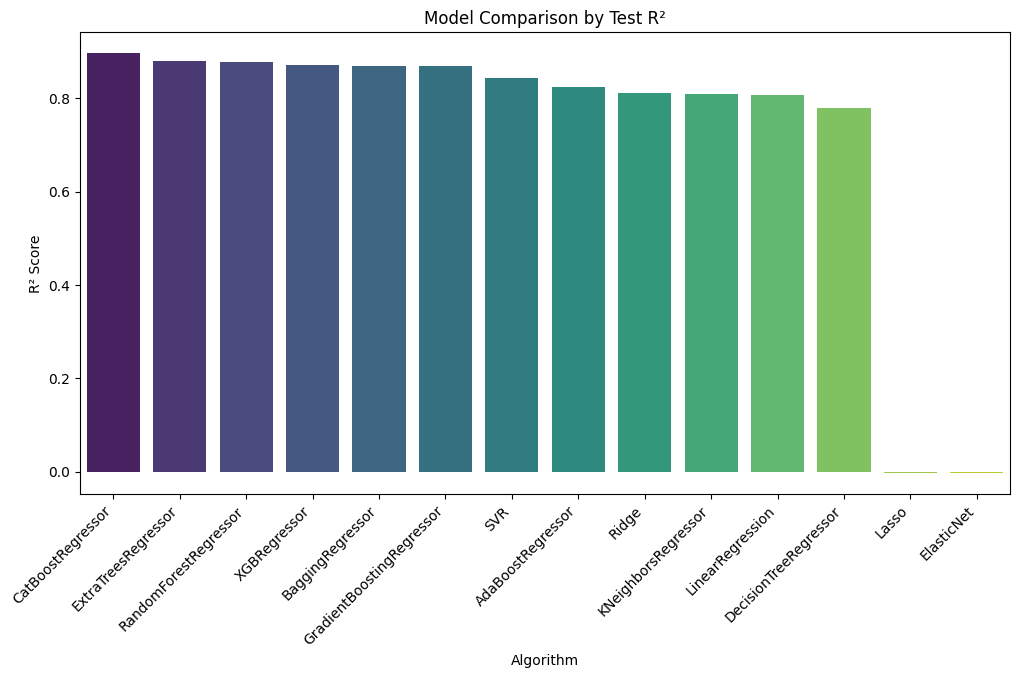

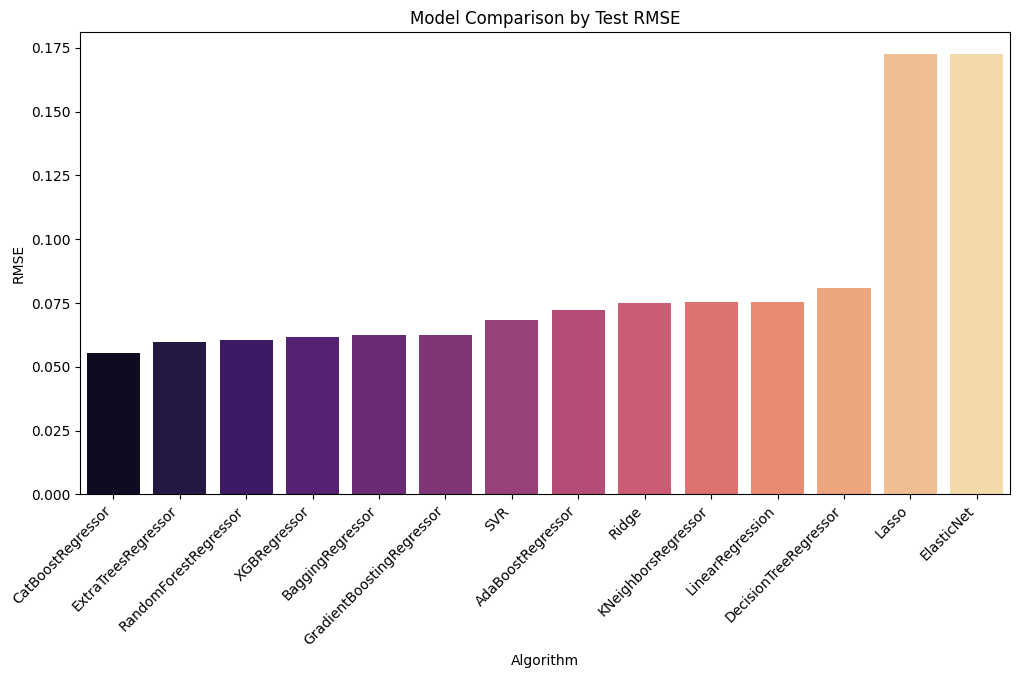

In [199]:
results_df = evaluate_models(models, X_train_pre, y_train_pre, X_test_pre, y_test_pre, cv=5)
plot_results(results_df)

In [200]:
results_df

,CV Train R2,CV Train MAE,CV Train RMSE,Train R2,Train MAE,Train RMSE,Train MAPE,Test R2,Test MAE,Test RMSE,Test MAPE
Algorithm,,,,,,,,,,,
CatBoostRegressor,0.973873,0.021253,0.027741,0.970266,0.022596,0.029608,6.747371,0.896206,0.039830,0.055492,10.188452
ExtraTreesRegressor,0.997977,0.001703,0.007717,0.997460,0.002112,0.008653,0.553776,0.880337,0.042396,0.059583,11.158640
RandomForestRegressor,0.981169,0.017628,0.023548,0.982338,0.017048,0.022819,5.080173,0.877432,0.042555,0.060302,11.652685
XGBRegressor,0.993880,0.008635,0.013433,0.990813,0.011151,0.016458,3.404954,0.872082,0.041939,0.061604,11.129666
BaggingRegressor,0.976030,0.018927,0.026573,0.976562,0.018961,0.026287,5.622475,0.869058,0.043127,0.062328,12.065824
GradientBoostingRegressor,0.919151,0.038151,0.048805,0.914515,0.039337,0.050202,11.916960,0.868994,0.046144,0.062343,12.170854
SVR,0.866731,0.052362,0.062652,0.870078,0.051350,0.061890,16.868962,0.843418,0.051813,0.068158,14.792436
AdaBoostRegressor,0.829724,0.058458,0.070801,0.822249,0.059424,0.072391,20.395827,0.824855,0.055958,0.072085,16.245511
Ridge,0.827923,0.056893,0.071202,0.826568,0.057175,0.071506,17.532978,0.811391,0.055958,0.074804,15.475470


CatBoost, ExtraTrees, and RandomForest are leading the pack — low RMSE and high R².
Lasso and ElasticNet are struggling — their R² is much lower, and RMSE is higher. 

Since laptop prices depend on interactions (e.g. CPU tier × RAM × GPU brand). Linear models can’t capture those interactions but tree ensembles perform much better.

CatBoostRegressor has a test R² of 0.896, test MAPE of 10% and test RMSE 0.055. This performs well on both CV, training data and test data.

ExtraTeesRegressor, RandomForestRegressor and XGBRegressor have near-perfect train R² (0.998) but lower test R², thus showing overfitting.

Next, we try hypertuning the features using RandomizedSearchCv.

<h4>CatBoostRegressor</h4>

In [201]:
from scipy.stats import loguniform, randint, uniform

cb = CatBoostRegressor(
    loss_function = "RMSE",
    verbose = False,
    random_state = 42
)

cb_distributions = {
    "depth": randint(4, 11),  #tree depth
    "learning_rate": loguniform(1e-3, 3e-1),
    "l2_leaf_reg": loguniform(1e-2, 1e2),  #regularization
    "bagging_temperature": uniform(0.0, 1.0),  #randomness
    "border_count": randint(64, 256),  #splits per feature
    "iterations": randint(500, 1501)  #trees
}

cb_rand = RandomizedSearchCV(
    estimator = cb,
    param_distributions = cb_distributions,
    n_iter = 60,
    scoring = "neg_root_mean_squared_error",
    cv = 5,    #5-fold cross validation
    random_state = 42,
    n_jobs = -1,
    verbose = 1
)

cb_rand.fit(X_train_pre, y_train_pre.to_numpy().ravel())
print("CB best params:", cb_rand.best_params_)
print("CB best CV RMSE:", -cb_rand.best_score_)

bp = cb_rand.best_params_
cb_grid = GridSearchCV(
    estimator = cb,
    param_grid={
        "depth": [max(4, bp["depth"]-1), bp["depth"], bp["depth"]+1],
        "learning_rate": [bp["learning_rate"]*0.5, bp["learning_rate"], bp["learning_rate"]*1.5],
        "l2_leaf_reg": [bp["l2_leaf_reg"]*0.5, bp["l2_leaf_reg"], bp["l2_leaf_reg"]*2],
        "iterations": [max(300, bp["iterations"]-200), bp["iterations"], bp["iterations"]+200]
    },
    scoring = "neg_root_mean_squared_error",
    cv = 5,
    n_jobs = -1,
    verbose = 1
)

cb_grid.fit(X_train_pre, y_train_pre.to_numpy().ravel())
print("CB grid best params:", cb_grid.best_params_)
print("CB grid best CV RMSE:", -cb_grid.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
CB best params: {'bagging_temperature': np.float64(0.8583588048137198), 'border_count': 250, 'depth': 7, 'iterations': 902, 'l2_leaf_reg': np.float64(6.9919470342940935), 'learning_rate': np.float64(0.10121205599948264)}
CB best CV RMSE: 0.05676144520949864
Fitting 5 folds for each of 81 candidates, totalling 405 fits
CB grid best params: {'depth': 7, 'iterations': 702, 'l2_leaf_reg': np.float64(6.9919470342940935), 'learning_rate': np.float64(0.10121205599948264)}
CB grid best CV RMSE: 0.05670449243986473


<h4>XGBRegressor</h4>

In [202]:
xgb = XGBRegressor(
    objective = "reg:squarederror",
    tree_method = "hist",
    random_state = 42,
    n_jobs = -1
)

xgb_distributions = {
    "n_estimators": randint(300, 1500),  #no of trees
    "max_depth": randint(3, 11),
    "learning_rate": loguniform(1e-3, 3e-1),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),   # 0.6..1.0
    "min_child_weight": randint(1, 11),  #prevens splits on small leaves
    "reg_alpha": loguniform(1e-8, 1e-1),
    "reg_lambda": loguniform(1e-2, 1e2)
}

xgb_rand = RandomizedSearchCV(
    estimator = xgb,
    param_distributions = xgb_distributions,
    n_iter = 80,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_rand.fit(X_train_pre, y_train_pre.to_numpy().ravel())
print("XGB best params:", xgb_rand.best_params_)
print("XGB best CV RMSE:", -xgb_rand.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
XGB best params: {'colsample_bytree': np.float64(0.7213062058692892), 'learning_rate': np.float64(0.02140022285353342), 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 563, 'reg_alpha': np.float64(0.002454453855780895), 'reg_lambda': np.float64(0.0729934868306231), 'subsample': np.float64(0.8491561903276001)}
XGB best CV RMSE: 0.05571254809534678


<h4>RandomForestRegressor</h4>

In [203]:
rf = RandomForestRegressor(
    random_state = 42,
    n_jobs = -1
)

rf_distributions = {
    "n_estimators": randint(300, 1200),
    "max_depth": randint(4, 31),             #deeper trees -> overfit
    "max_features": ["sqrt", "log2", 0.6, 0.8, 1.0],  
    "min_samples_split": randint(2, 21),
    "min_samples_leaf": randint(1, 11),
    "bootstrap": [True, False]
}

rf_rand = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_distributions,
    n_iter=60,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_rand.fit(X_train_pre, y_train_pre.to_numpy().ravel())
print("RF best params:", rf_rand.best_params_)
print("RF best CV RMSE:", -rf_rand.best_score_)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
RF best params: {'bootstrap': True, 'max_depth': 17, 'max_features': 0.6, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 517}
RF best CV RMSE: 0.06066627840363596


<h4>ExtraTreesRegressor</h4>

In [207]:
et = ExtraTreesRegressor(
    n_estimators = 500,
    random_state = 42,
    n_jobs = -1
)

et.fit(X_train_pre, y_train_pre.to_numpy().ravel())

,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


<h4>Evaluation</h4>

In [243]:
def eval_model(model, X, y):
    y_pred_scaled = model.predict(X).reshape(-1,1)

    # Inverse transform if possible
    if hasattr(full_pipeline1, "y_pipeline") and hasattr(full_pipeline1.y_pipeline, "inverse_transform"):
        try:
            y_pred = full_pipeline1.y_pipeline.inverse_transform(y_pred_scaled).ravel()
        except Exception:
            y_pred = y_pred_scaled.ravel()
    else:
        y_pred = y_pred_scaled.ravel()

    y_true = y.to_numpy().ravel() if hasattr(y, "to_numpy") else np.array(y).ravel()

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return mae, rmse, r2, mape

Voting Regressor - combines predictions from multiple models and gives a simple or weighted average.

In [210]:
from sklearn.ensemble import VotingRegressor

selected_models = [
    ('cb', cb_rand.best_estimator_),
    ('xgb', xgb_rand.best_estimator_),
    ('et', et)
]

w = [3, 2, 2]

voting_reg = VotingRegressor(
    estimators = selected_models,
    weights = w
)

voting_reg.fit(X_train_pre, y_train_pre.to_numpy().ravel())

,estimators,"[('cb', ...), ('xgb', ...), ...]"
,weights,"[3, 2, ...]"
,n_jobs,None
,verbose,False
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,np.float64(0.7213062058692892)


Stacking Regressor - trains a meta-model on top of our selected models' predictions.

In [209]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

stacking_reg = StackingRegressor(
    estimators = selected_models,
    final_estimator = RidgeCV(alphas=np.logspace(-3, 3, 13)),
    cv = 5,
    passthrough = False
)

stacking_reg.fit(X_train_pre, y_train_pre.to_numpy().ravel())

,estimators,"[('cb', ...), ('xgb', ...), ...]"
,final_estimator,RidgeCV(alpha...0000000e+03]))
,cv,5
,n_jobs,None
,passthrough,False
,verbose,0
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


In [244]:
models_to_compare = {
    "CatBoost": cb_rand.best_estimator_,
    "XGB": xgb_rand.best_estimator_,
    "ExtraTrees": et,
    "Voting": voting_reg,
    "Stacking": stacking_reg
}

results = []
for name, model in models_to_compare.items():
    mae_train, rmse_train, r2_train, mape_train = eval_model(model, X_train_pre, y_train)
    mae_test, rmse_test, r2_test, mape_test = eval_model(model, X_test_pre, y_test)

    results.append({
        "Model": name,
        "Train MAE": mae_train,
        "Train RMSE": rmse_train,
        "Train R²": r2_train,
        "Train MAPE (%)": mape_train,
        "Test MAE": mae_test,
        "Test RMSE": rmse_test,
        "Test R²": r2_test,
        "Test MAPE (%)": mape_test
    })

    
results_df = pd.DataFrame(results).set_index("Model")
print(results_df)

              Train MAE   Train RMSE  Train R²  Train MAPE (%)     Test MAE  \
Model                                                                         
CatBoost    3299.885198  5074.433123  0.981547        5.662868  9521.590111   
XGB         2545.109246  4106.455035  0.987916        4.410407  9209.922911   
ExtraTrees   481.906766  2334.878559  0.996093        0.757371  9656.039480   
Voting      2242.876995  3700.818350  0.990185        3.834567  9207.591273   
Stacking    2807.386664  4415.546068  0.986028        4.872146  9196.546377   

               Test RMSE   Test R²  Test MAPE (%)  
Model                                              
CatBoost    16116.261184  0.810857      14.192085  
XGB         15618.335093  0.822364      13.923071  
ExtraTrees  16253.198092  0.807629      14.820150  
Voting      15598.150112  0.822823      13.810459  
Stacking    15633.809432  0.822012      13.832895  


XGB is the best single model but voting ensemble wins overall. It has the best performance in every single matrix.

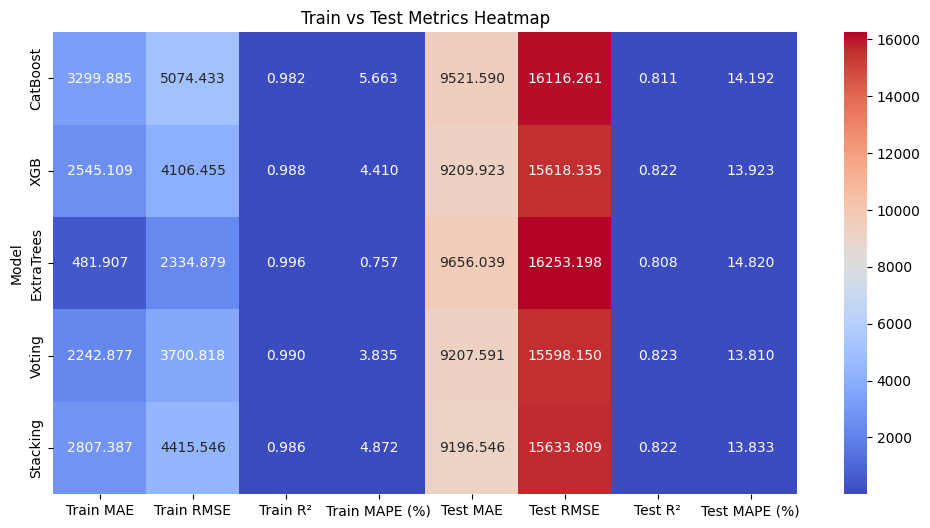

In [245]:
# Heatmap visualization
plt.figure(figsize=(12,6))
sns.heatmap(results_df, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)
plt.title("Train vs Test Metrics Heatmap")
plt.show()

Plotting predicted data vs actual prices:

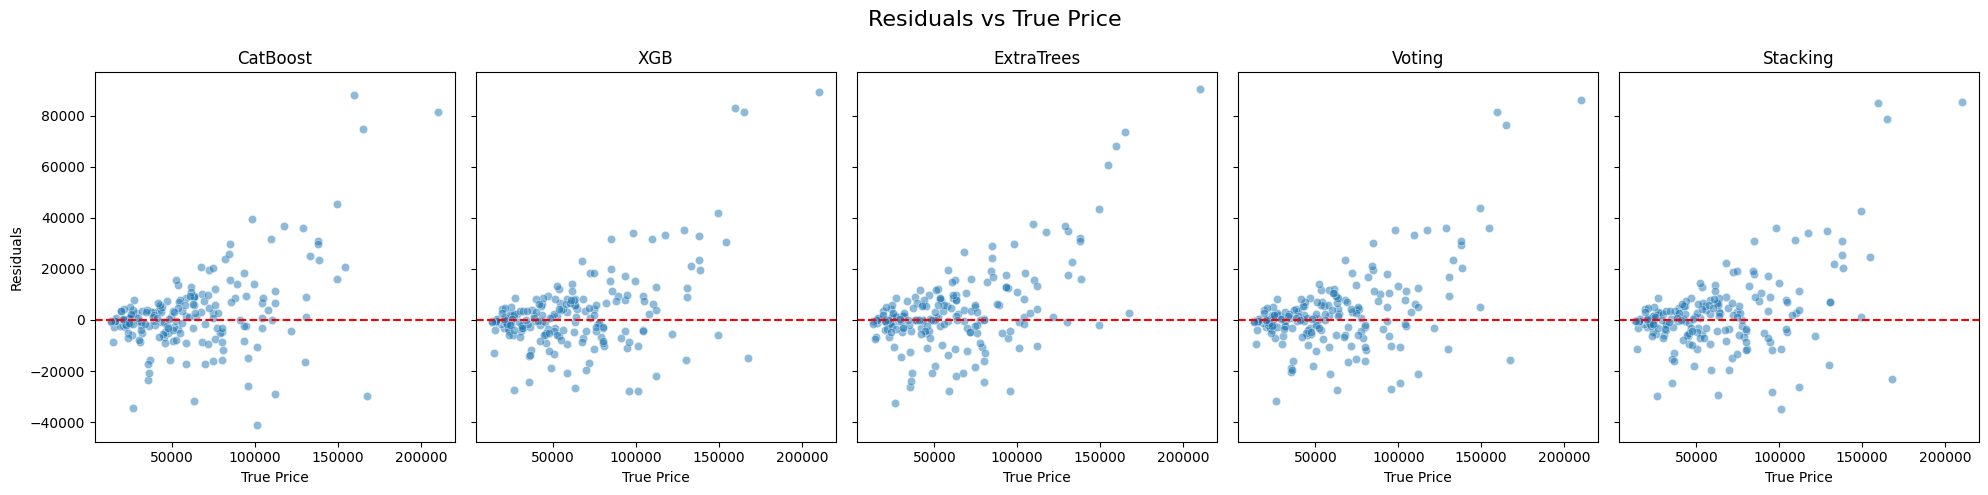

In [232]:
def plot_residuals(models_dict, X, y):
    fig, axes = plt.subplots(1, len(models_dict), figsize=(20,5), sharey=True)
    y_true = y.to_numpy().ravel() if hasattr(y, "to_numpy") else np.array(y).ravel()
    
    for ax, (name, model) in zip(axes, models_dict.items()):
        y_pred_scaled = model.predict(X).reshape(-1,1)
        try:
            y_pred = full_pipeline1.y_pipeline.inverse_transform(y_pred_scaled).ravel()
        except AttributeError:
            y_pred = y_pred_scaled.ravel()
        
        residuals = y_true - y_pred
        sns.scatterplot(x=y_true, y=residuals, alpha=0.5, ax=ax)
        ax.axhline(0, color="red", linestyle="--")
        ax.set_title(f"{name}")
        ax.set_xlabel("True Price")
        ax.set_ylabel("Residuals")
    
    plt.suptitle("Residuals vs True Price", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_residuals(models_to_compare, X_test_pre, y_test)

Residuals are mostly scattered around zero, which is ideal.

At higher prices, residuals are more. So the models have trouble predicting expensive laptops.

No sign of bias.

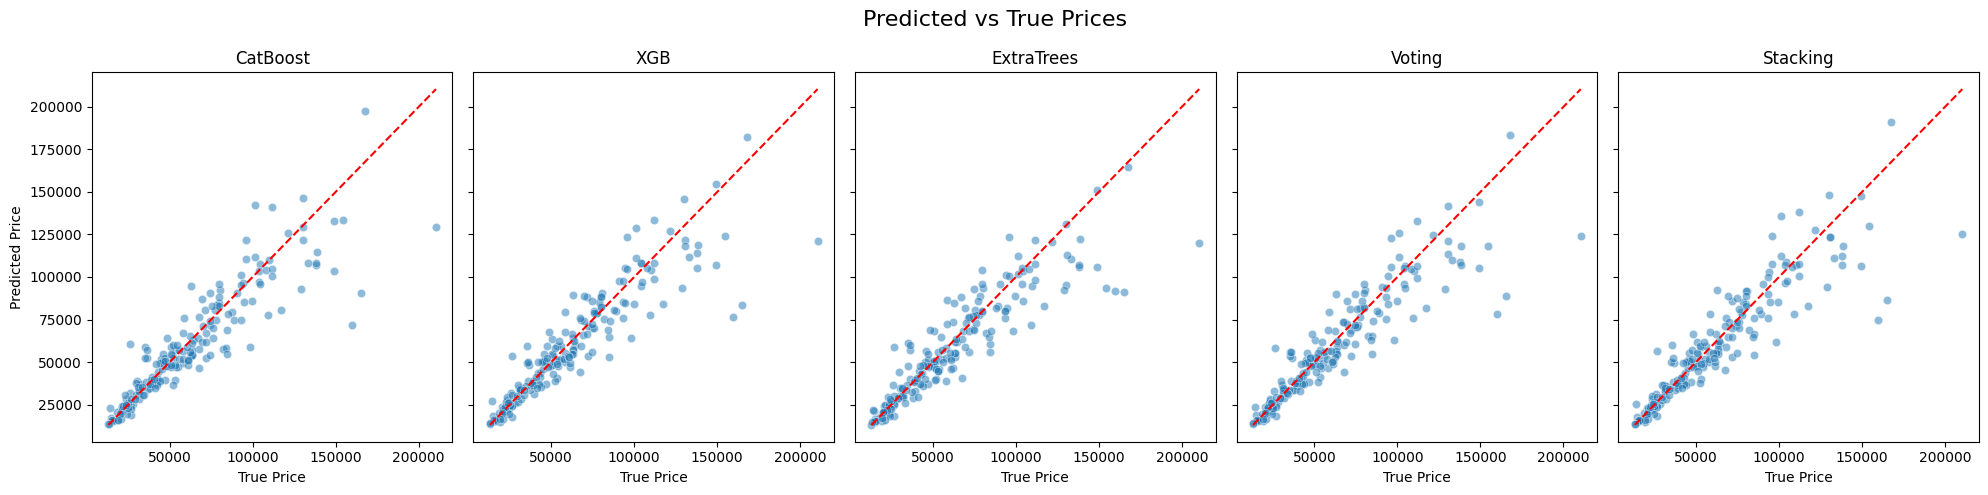

In [233]:
def plot_pred_vs_true(models_dict, X, y):
    fig, axes = plt.subplots(1, len(models_dict), figsize=(20,5), sharex=True, sharey=True)
    y_true = y.to_numpy().ravel() if hasattr(y, "to_numpy") else np.array(y).ravel()
    
    for ax, (name, model) in zip(axes, models_dict.items()):
        y_pred_scaled = model.predict(X).reshape(-1,1)
        try:
            y_pred = full_pipeline1.y_pipeline.inverse_transform(y_pred_scaled).ravel()
        except AttributeError:
            y_pred = y_pred_scaled.ravel()
        
        sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, ax=ax)
        lim = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
        ax.plot(lim, lim, 'r--')
        ax.set_title(f"{name}")
        ax.set_xlabel("True Price")
        ax.set_ylabel("Predicted Price")
    
    plt.suptitle("Predicted vs True Prices", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_pred_vs_true(models_to_compare, X_test_pre, y_test)

XGB and Voting hug the diagonal line most closely showing best calibration.

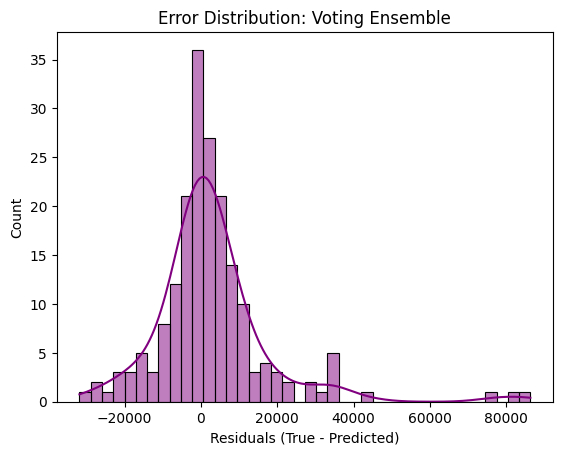

In [234]:
def plot_error_distribution(model, X, y, model_name="Model"):
    y_true = y.to_numpy().ravel() if hasattr(y, "to_numpy") else np.array(y).ravel()
    y_pred_scaled = model.predict(X).reshape(-1,1)
    try:
        y_pred = full_pipeline1.y_pipeline.inverse_transform(y_pred_scaled).ravel()
    except AttributeError:
        y_pred = y_pred_scaled.ravel()
    
    residuals = y_true - y_pred
    sns.histplot(residuals, kde=True, bins=40, color="purple")
    plt.title(f"Error Distribution: {model_name}")
    plt.xlabel("Residuals (True - Predicted)")
    plt.show()

plot_error_distribution(models_to_compare["Voting"], X_test_pre, y_test, "Voting Ensemble")

The Error Distribution histogram is centred around zero. Thus the ensemble doesn't systematically over or under predict.

The distribution is fairly tight but with longer tails indicating that occassionaly large errors exist (likely for outliers).

The model is generally reliable, but struggles with unusual laptops/outliers.

<h4>Feature Importance</h4>

We check which features drive the price using XGB's built-in feature importance.

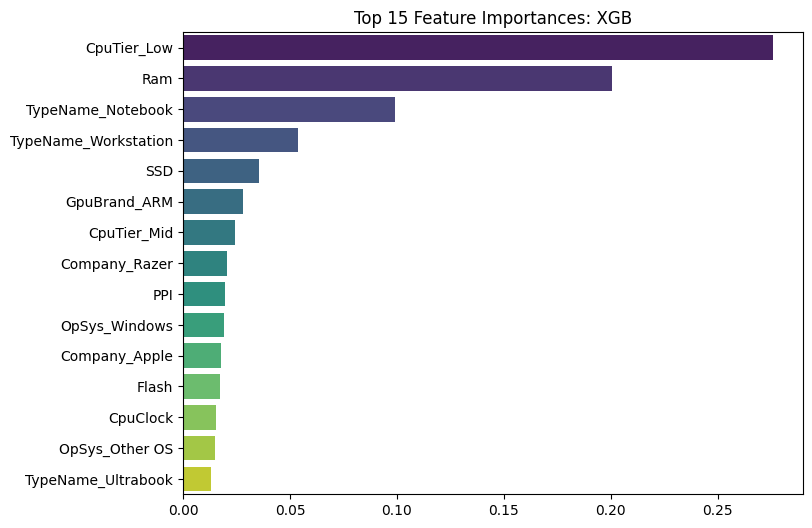

In [237]:
def plot_feature_importance(model, feature_names, model_name="Model"):
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(8,6))
    sns.barplot(x=importances[idx][:15], y=np.array(feature_names)[idx][:15], palette="viridis")
    plt.title(f"Top 15 Feature Importances: {model_name}")
    plt.show()


feature_names = [
    name.split("__")[-1] for name in 
    full_pipeline1.full_pipeline.named_steps['preprocessor'].get_feature_names_out()
]
plot_feature_importance(xgb_rand.best_estimator_, feature_names, "XGB")

CpuTier_Low dominates, thus CPU tier is the strongest driver of price.
Next up is Ram, which is a good indicative of laptop price. 

TypeName categories also matter but this could a bias since we are using a tree based model.

SSD, PPI, GPU brand etc are also significant features.

<h4>Permutation Importance</h4>

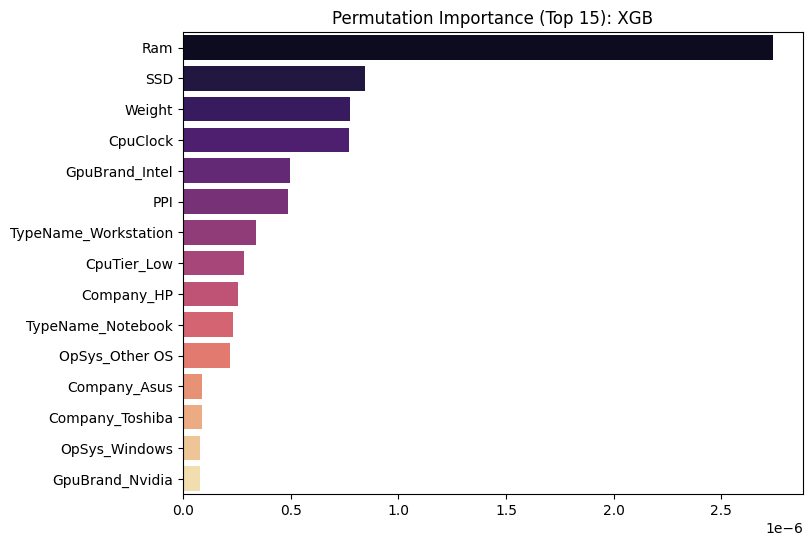

In [ ]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(model, X, y, feature_names, model_name="Model"):
    r = permutation_importance(model, X, y.to_numpy().ravel(), n_repeats=10, random_state=42, n_jobs=-1)
    sorted_idx = r.importances_mean.argsort()[::-1]
    plt.figure(figsize=(8,6))
    sns.barplot(x=r.importances_mean[sorted_idx][:15], y=np.array(feature_names)[sorted_idx][:15], palette="magma")
    plt.title(f"Permutation Importance (Top 15): {model_name}")
    plt.show()
    

plot_permutation_importance(xgb_rand.best_estimator_, X_test_pre, y_test, feature_names, "XGB")

Ram and SSD again dominates here, confirming that they truly are the driving force behind price prediction. Weight, CPU Clock and PPI emerge as important features here, suggesting that the model relies on them heavily.

Company names show up but they do not have much hand in driving up price values. This shows that hardware specs are more coveting than brand name effects.

<h4>SHAP</h4>

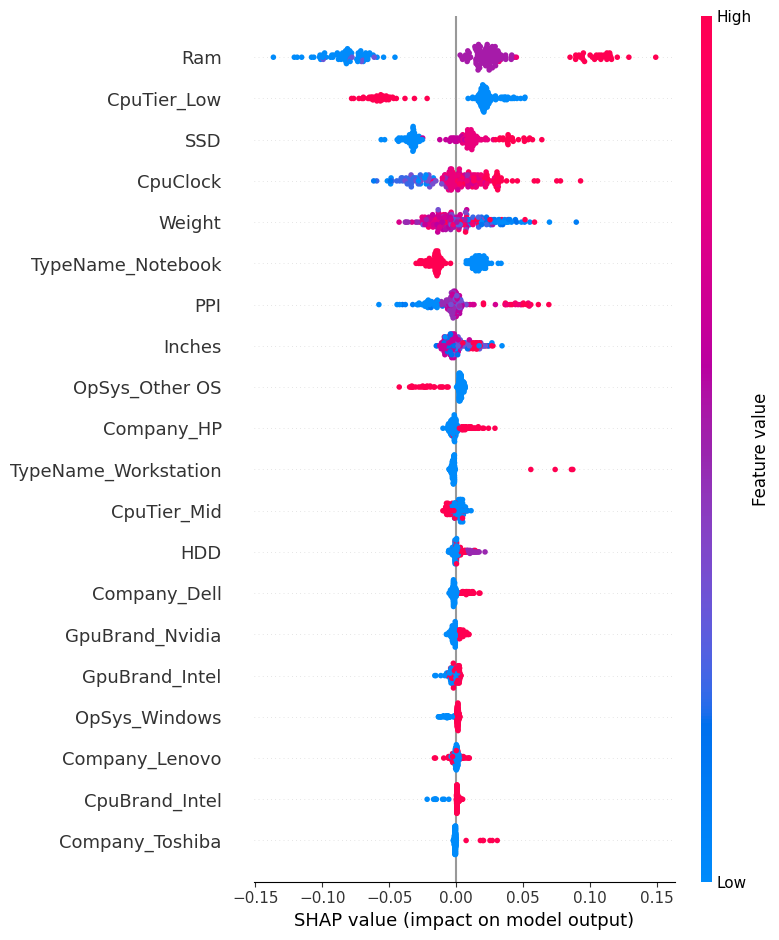

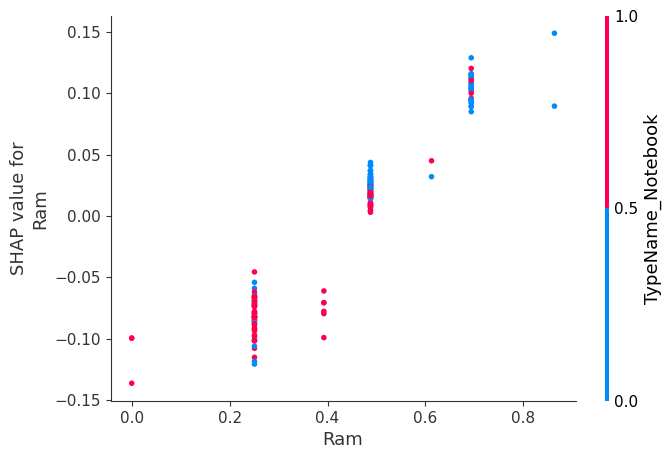

In [240]:
import shap

explainer = shap.TreeExplainer(xgb_rand.best_estimator_)
shap_values = explainer.shap_values(X_test_pre)

# Global summary plot
shap.summary_plot(shap_values, X_test_pre, feature_names)

# Dependence plot for a key feature (e.g., 'Ram')
shap.dependence_plot("Ram", shap_values, X_test_pre, feature_names)

- Ram: High RAM strongly increases predicted price.

- CpuTier_Low: Being in the “low” tier strongly decreases predicted price.

- SSD: Presence of SSD pushes predictions upward.

- CpuClock, Weight, PPI: Continuous features with clear monotonic effects (higher clock speed, higher PPI, lighter weight leads to higher price).

- Categorical brand/product effects are also captured

<h4>Analysis</h4>

We evaluated five models — CatBoost, XGBoost, ExtraTrees, Voting Ensemble, and Stacking Ensemble — using both training and test sets. Performance was assessed with MAE, RMSE, R², and MAPE.

Model performance on the test set showed that:

- XGBoost was the strongest single model, achieving an RMSE of ~15,618 and R² of ~0.822.

- Voting Ensemble (CatBoost + XGB + ExtraTrees) delivered the best overall performance, with RMSE ~15,598 and R² ~0.823, edging out XGB alone.

Overfitting analysis using train vs test metrics revealed:

- Training and test errors were relatively close, suggesting that none of the models severely overfit.

- ExtraTrees showed slightly larger train–test gaps, consistent with its tendency to memorize training data.

- Boosting models (XGB, CatBoost) and the Voting ensemble generalized well, with balanced performance across train and test sets.

Residual analysis confirmed that:

- Errors were centered around zero, indicating no systematic bias.

- Residuals widened at higher price ranges, showing that all models struggled more with predicting very expensive laptops.

- The Voting ensemble produced the tightest residual spread, supporting its superior generalization.

Feature importance and interpretability:

- Built‑in importance (XGB) emphasized categorical splits such as CpuTier_Low and TypeName.

- Permutation importance highlighted continuous features like Ram, SSD, Weight, and CpuClock.

- SHAP analysis unified these perspectives, showing that high RAM, SSD presence, higher CPU clock, and higher PPI consistently pushed predictions upward, while low CPU tier and heavier weight reduced predicted price. Brand effects (Apple, HP, Dell) also contributed, reflecting real‑world pricing premiums.

<h4>Discussion</h4>

- The results align with domain knowledge: laptop prices are primarily driven by performance specs (RAM, CPU, SSD), display quality (PPI, Inches), and brand/product positioning.

- The ensemble approach (Voting) provided a small but consistent improvement over the best single model (XGB), demonstrating the value of combining diverse learners.

- The models remain less accurate at the extremes (very high‑end laptops), suggesting that additional features (e.g., GPU tier, release year, marketing segment) or more data could further improve performance.

- Overall, the Voting ensemble is the recommended model for deployment, offering the best balance of accuracy and robustness.